# US Census income - Predictive Modeling
### Author: Pierre Petrella

# Presenting the Study
Every ten years the United States Census Bureau conducts a mine information regarding the US population in order to inform the allocation of billions of dollars of funding to various endevors. </br>

The goal of the assesment is to find the features that are associated to a person making more or less than $50,000 per year. </br>

Once those features identified, the goal is to construct a data analysis/modeling pipeline for this problem. </br>

To do so we will split the pipeline into 5 sections: </br>

1. Data analysis
2. Data cleaning and Feature Engineering
3. Building predictive models
4. Model assessment
5. Results

At our disposant we have:
- training set
    - 199523 instances
- testing set
    - 99762 instances
- metadata on the census features

# 0. Initialising the Study

In [1]:
# Imports

# Visualisation 
import matplotlib.pyplot as plt
import seaborn as sns

# Data Manipulation
import random
import pandas as pd
import numpy as np
import json
import ast

# Statistical Tests
from scipy.stats import ttest_ind

# Modelling
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

import xgboost as xgb

#import custom functions
from census_functions import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)

# Set configuration parameters
random_seed = 0
random.seed = random_seed

In [3]:
# Set the paths to go download data from the source
path_col = "../data/colNames.json"
path_census_test = "../data/census_income_test.csv"
path_census_learn = "../data/census_income_learn.csv"

In [4]:
# Fetch the column names form the metadata and store theme into a dictionary
a_file = open(path_col, "r")
header_dict = ast.literal_eval((a_file.read()))
a_file.close()

In [5]:
# Fetch training and testing data integrating the column metadata

col_names = list(header_dict.values())
census_learn = pd.read_csv(path_census_learn, names = col_names, index_col=False)
census_test = pd.read_csv(path_census_test, names = col_names, index_col=False)

In [6]:
# Quick visualization of the first lines of the dataset

census_learn.head(3)

,age,class of worker,industry code,occupation code,education,wage per hour,enrolled in edu inst last wk,marital status,major industry code,major occupation code,race,hispanic Origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer status,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,instance weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income classification
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.


In [7]:
# Listing and separating types of features

features = list(census_learn.columns)
features.remove("income classification")

continuous_features = ['age', 'wage per hour', 'capital gains',
                      'capital losses', 'dividends from stocks',
                      'instance weight', 'num persons worked for employer',
                      'weeks worked in year']
categorical_features = [feat for feat in features if feat not in continuous_features]

print("Total number of attributes: {}".format(len(features)))
print()
print("There are {} categorical features:".format(len(categorical_features)))
print(categorical_features)
print()
print("There are {} continuous features:".format(len(continuous_features)))
print(continuous_features)

Total number of attributes: 41

There are 33 categorical features:
['class of worker', 'industry code', 'occupation code', 'education', 'enrolled in edu inst last wk', 'marital status', 'major industry code', 'major occupation code', 'race', 'hispanic Origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'tax filer status', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin", 'veterans benefits', 'year']

There are 8 continuous features:
['age', 'wage per hour', 'capital gains', 'capital

# 1. Data analysis

In this section we will study all the features using univariate and bivariate analysis.</br>
The study of the features will be split into 3 parts:
1. Study of the target label
2. Study of Continuous features
3. Study of Categorical features

### 1.1. Study of the target label
#### Objective:
To understand the problem and the possible challenges, it is important to visualize the target variable that we aim to predict. In this case, we are dealing with a binary classification problem. The goal being to predict if an individual makes more or less than $50,000 annually.


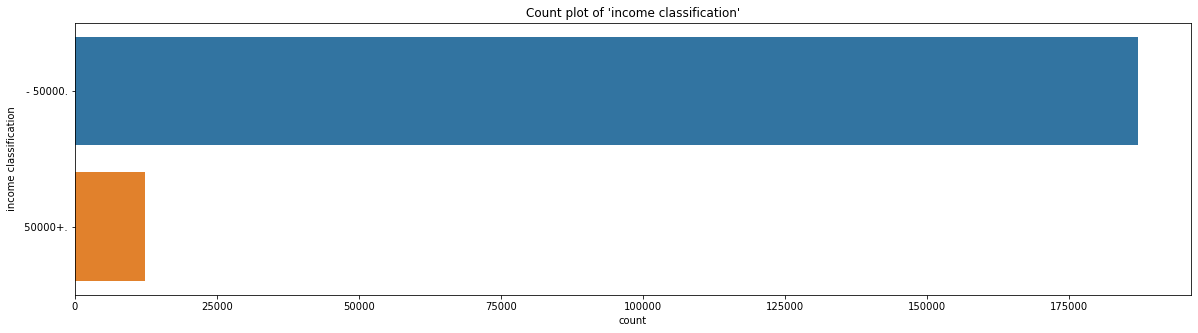

In [8]:
# Visualizing the distribution of the target labels

categorical_univariate_plot(census_learn,"income classification")

#### Observation:
- Probability for the label '- 50000' : 93.80% <br />
- Probability for the label '50000+' : 6.20% <br />
- Modeles will take a big risk when predicting '50000+'

#### Key takeaway
- Majority accuracy: 93.80% on value - 50000 <br />
- The models trained need to have a greater accuacy than 93.80% to be relevant.
- A resampling of the data might be required to reduce bias

## 1.2. Study of Continuous features

### 1.2.1. Univariate Study of Continuous features
#### Objective
In this study the aime is to visualize the distribution of the continuous featres using:
- histograms
- statistical measurments to describe each feature:
    - **count** : nbr of elements in the set
    - **mean** : average of values
    - **std** : standard deviation
    - **min** : min value
    - **25%** : first quartile
    - **50%** : median
    - **75%** : third quartile
    - **max** : max value
    - **skew** : indicator of non symmetrical distribution 
    - **kurtosis** : indicator of "tailedness" of a distribution

The continuous features are: ['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'instance weight', 'num persons worked for employer', 'weeks worked in year']


,age,wage per hour,capital gains,capital losses,dividends from stocks,instance weight,num persons worked for employer,weeks worked in year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,55.426908,434.718990,37.313788,197.529533,1740.380269,1.956180,23.174897
std,22.310895,274.896454,4697.531280,271.896428,1984.163658,993.768156,2.365126,24.411488
min,0.000000,0.000000,0.000000,0.000000,0.000000,37.870000,0.000000,0.000000
25%,15.000000,0.000000,0.000000,0.000000,0.000000,1061.615000,0.000000,0.000000
50%,33.000000,0.000000,0.000000,0.000000,0.000000,1618.310000,1.000000,8.000000
75%,50.000000,0.000000,0.000000,0.000000,0.000000,2188.610000,4.000000,52.000000
max,90.000000,9999.000000,99999.000000,4608.000000,99999.000000,18656.300000,6.000000,52.000000
skew,0.373290,8.935097,18.990822,7.632565,27.786502,1.432733,0.751561,0.210169
kurtosis,-0.732824,155.218897,393.062832,61.632933,1090.563754,5.412514,-1.082247,-1.863806


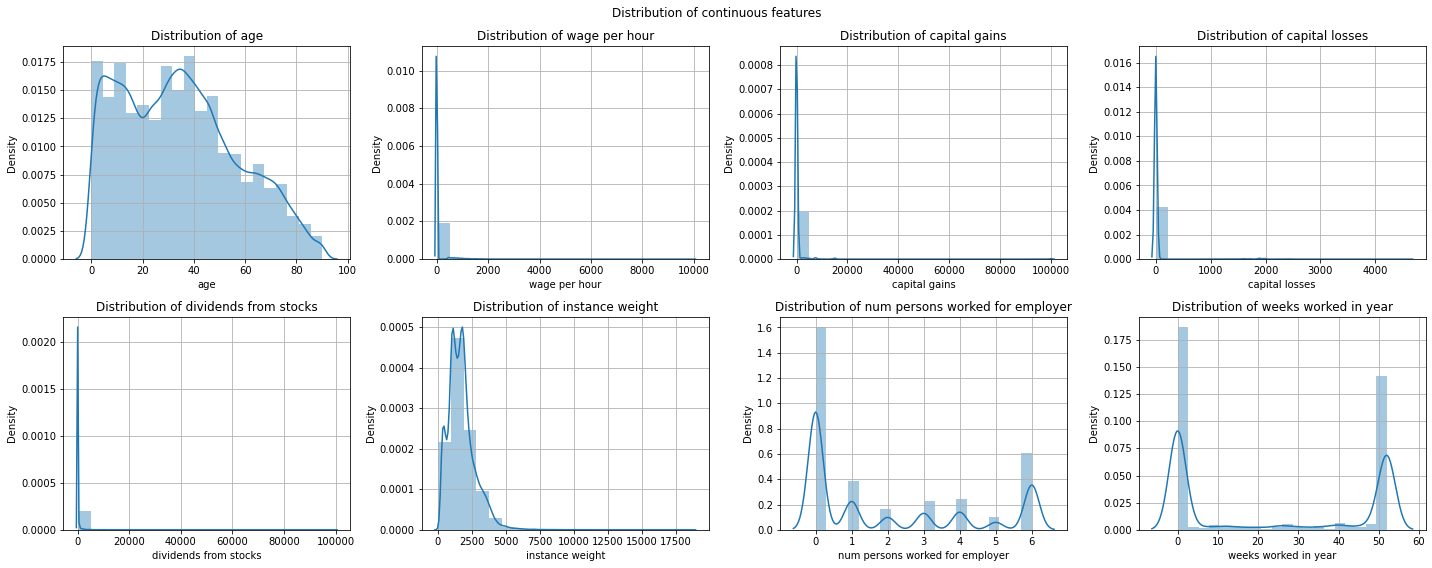

In [9]:
# Univariate Study of Continuous features
univariate_continuous_viz(census_learn, continuous_features)

#### Observation
**age**:
- mean : 34.5 years (which a good representation of the mean age in 1995)
- std : 22 years 
- Right skew: with skew=0.37, there is a slight skew toward the young polulation which should be considered when using it in a model.
    - the skewness can also be seen by comparing: medianv =33 < mean =34.5 

**wage per hour, capital gains, capital losses, dividends from stocks**:
- Right skewed, with a skew index>>0
- The high kurtosis value indicates that the distribution is tall and narrow as we can see on the histogram plots.
- the third quartile being at 0 shows that the majority of the value for these 4 metrics are 0.
- it would be interesting to compare these metrics with the age feature.

**instance weight**:
- mean : 1740.3 
- std : 993.8
- Right skew: (skew = 1.43) meaning that there is a tail of high values going up to 17000.

**num persons worked for employer**:
- mean : 1.95
- std : 2.4
- This continuous variable only has seven possible values.
- The majority of the value are either 0 or 6 (persons worked for employer).
- 0 might be the default value for unemployed or self-employed individuals that don'y have an employer.

**weeks worked in year**:
- mean : 23.2
- std : 24.4
- This feature could clearly be converted to a categorical feature.
- It apears that either 0 weeks were worked in a year or all 52 were worked.
- There are slightly less people working that people working.
    - This might be a consequence of the population age being skewed towards young people that might not work.


#### Key takeaway
- Models developped must take skew into consideration:
    - The age is skewed slightly towards a youger population but stays true to the average US age in 1995.
    - The four features related to earnings are highly skewed and are composed mainly of 0s.
- Finaly, some continuous feature tend to be more categrorical/polarised and could be considered as categorical features.


### 1.2.2 Bivariate study of continuous variables
#### Objective
- Compare continuous features with the target binary variable 
- Split each feature wrt the target value building two distributions
- Extract the mean of each class
- Compare the classes visualy.
    - using boxplots
- Statisticaly compare the two distribution using Welsh's test: 
    - Null Hypothese: "both distributions have the same mean"
    - The test requires that both samples taken from the distributions are normaly distributed.
    - This test doesn't require any assumption on the standard deviation of each distributions.
    


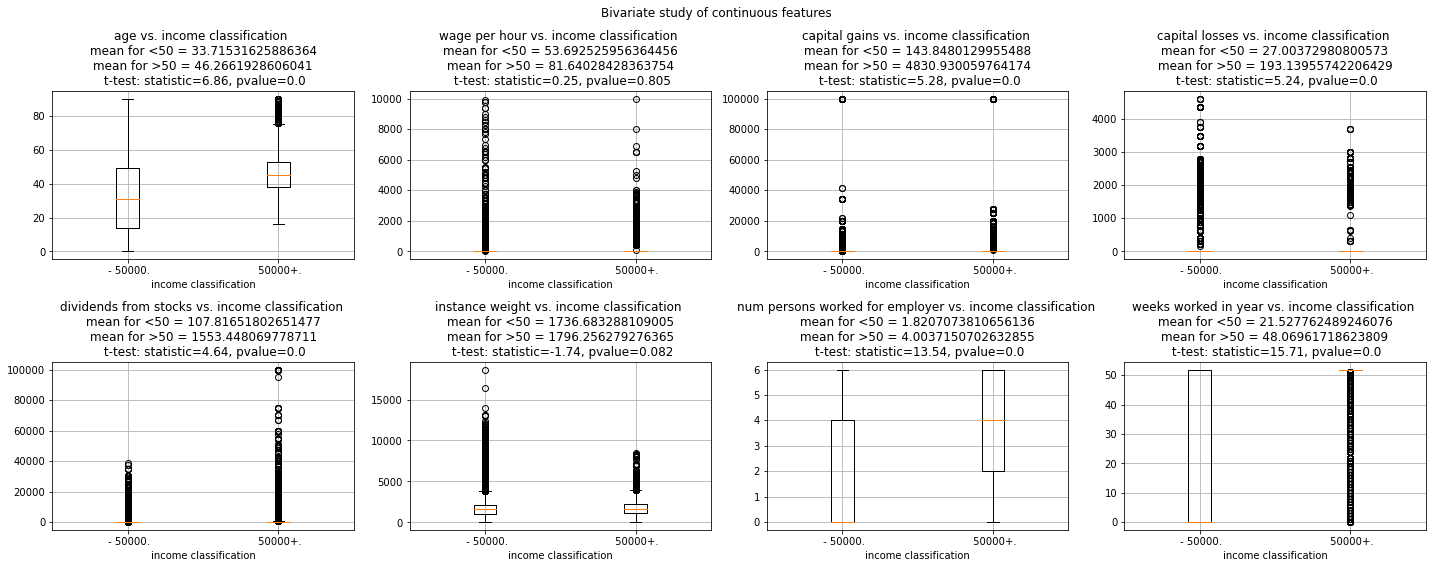

In [11]:
# Bivariate Study of Continuous features
bivariate_continuous_viz(census_learn, continuous_features, "income classification", 42)

#### Observation
For the distributions of continuous features that aren't skewed too much, the boxplots make it possible to visualize the difference between the two distributions. and their means.

Looking at the pvalue of Welsh's t-test, we set the pvalue's acceptable threashold at 0.05 which is the common threashold to decide whether or not to regect the null hypothesis. Since the pvalue>0.05 for the 'instance weight' feature is, we can't regest the null hypothesis that the two means of each distribution are equal.

For all the other features, we can safely regect the hypothesis and consider that the mean of the two classes are different.

When comparing the means we of the <50 with the >50 class, we can see that:
- The age is greater for the >50 class
    - 33.7 (<50) vs 46.3(>50)
- The wage per hour, capital gain, capital losses and dividents from stocks is also higher for the >50 class 
- On average more people work for the employer of the >50 class
- The vast magority of the the >50 class work all year long 


#### Key takeaway
- Using the t-test, we realise that the 'instance weight' is not a good feature to distinguish between classes
    - 'instance weight' should not be considered when training the models/
- All the other features are useful for this study
- IN general, people of the >50 class are older,and score higher on the categories related to money
    - (which is not suprising)


### 1.1.3 Multivariate study continuous variables
We have compared each feature individualy to the target feature. </br>
It would be interesting to look at the relationships between the features.
#### Objective
- Show correlation matrix between all 8 continuous features with a heat map 


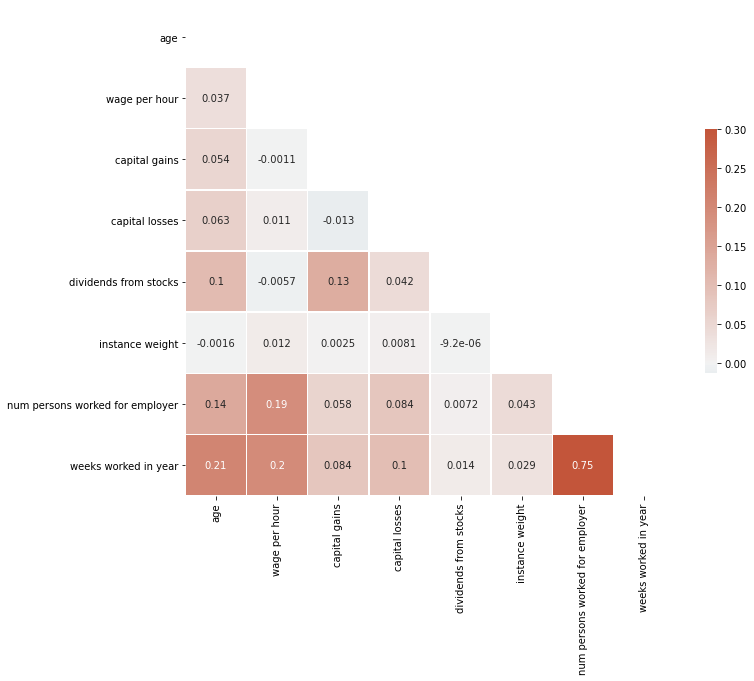

In [12]:
# Heatmap
# Compute the correlation matrix
correlation_continuous_viz(census_learn, continuous_features)

#### Observation
'number of persons worked for employer' is correlated to:
- 'weeks worked in a year' are highly correlated (corr=0.75)
    - The probably store the same information and we could possibly remove one/combine them to allow for dimention reduction
- wage per hour (corr=0.19)

'weeks worked in a year' is also fairly correlated to:
- age (corr = 0.21)
- wage per hour (corr 0.2)

The majority of the correlations are positive making each varaible proportional (with respect to inversly-proportional for negative correlation)

As all feature aren't completly independent, it would be interesting to considered dimention reduction removing certain features or applying PCA.

#### Key takeaway
- Some variables are correlated
- The dimention of the feature space could be reduced without affecting the model performances
    - It could also help speed up training and evaluation time


## 1.3.1 Study of Categorical Freatures

### Univariate study of categorical features
#### Objective
- Visualize the count of each categorical feature
- The size of each graph is computed dynamically so see bar plot of features with a lot of values.
- the number of distinct labels is computed for each label
- The most common label (mode) and it's frequency is computed as well

Distribution of the:'class of worker' categories
There are 9 distinct categories
Most common label is ' Not in universe' with 50%


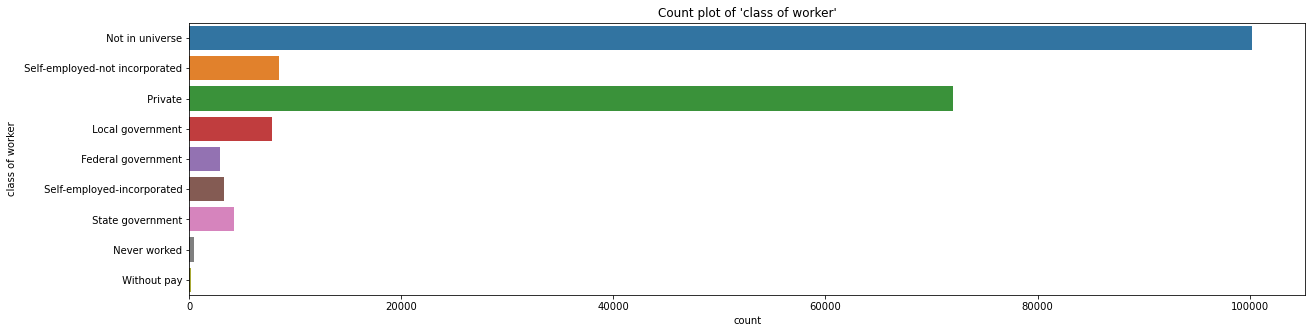

Distribution of the:'industry code' categories
There are 52 distinct categories
Most common label is '0' with 50%


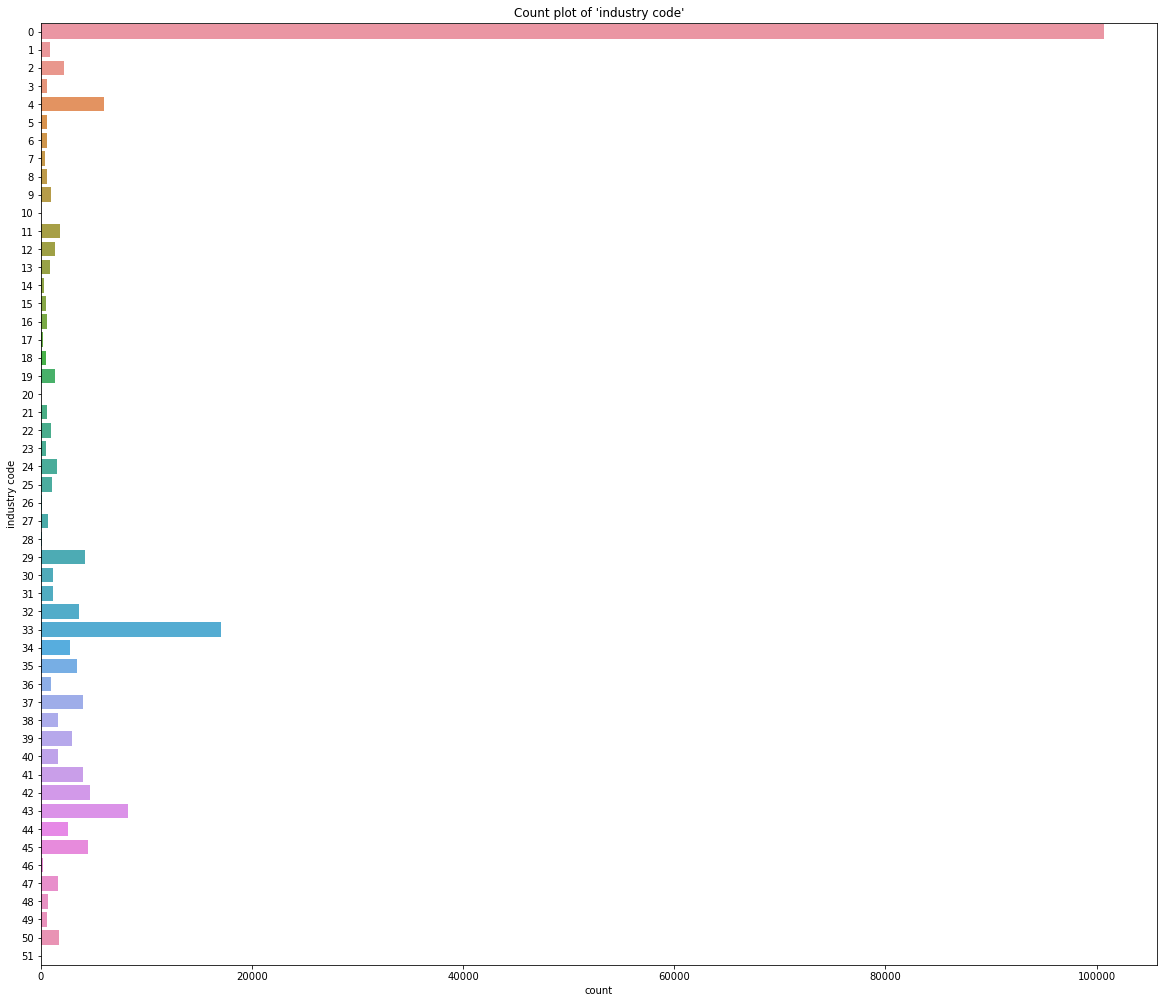

Distribution of the:'occupation code' categories
There are 47 distinct categories
Most common label is '0' with 50%


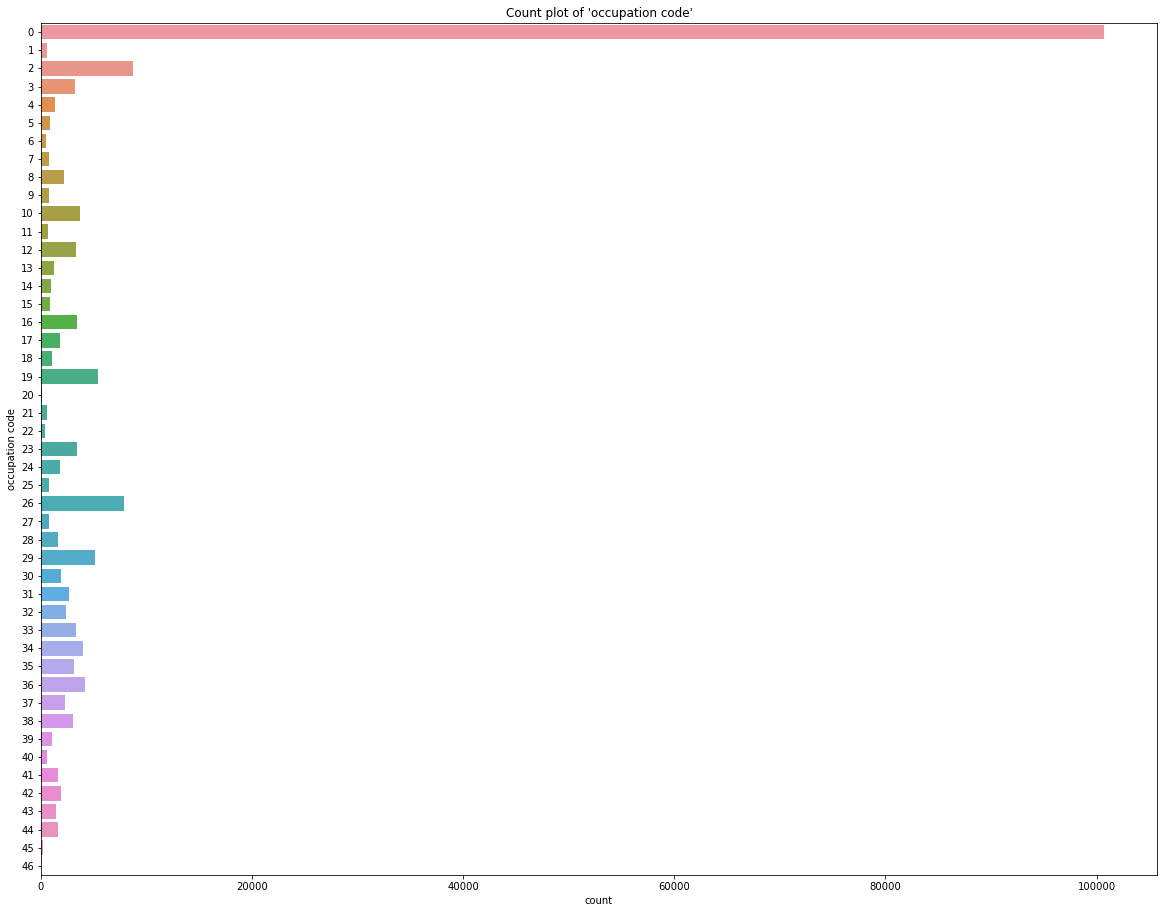

Distribution of the:'education' categories
There are 17 distinct categories
Most common label is ' High school graduate' with 24%


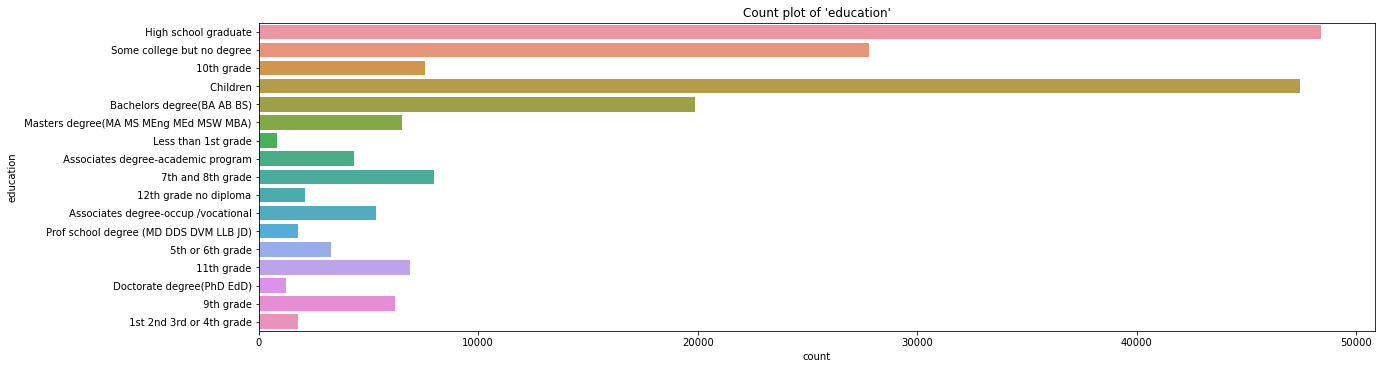

Distribution of the:'enrolled in edu inst last wk' categories
There are 3 distinct categories
Most common label is ' Not in universe' with 94%


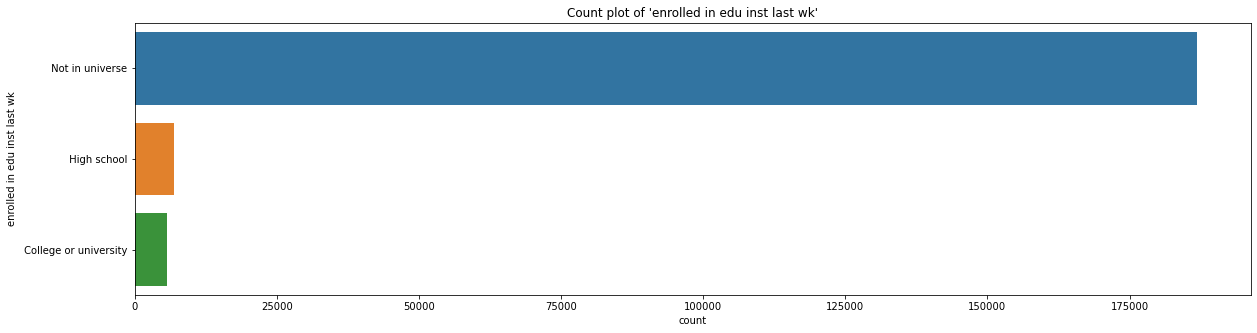

Distribution of the:'marital status' categories
There are 7 distinct categories
Most common label is ' Never married' with 43%


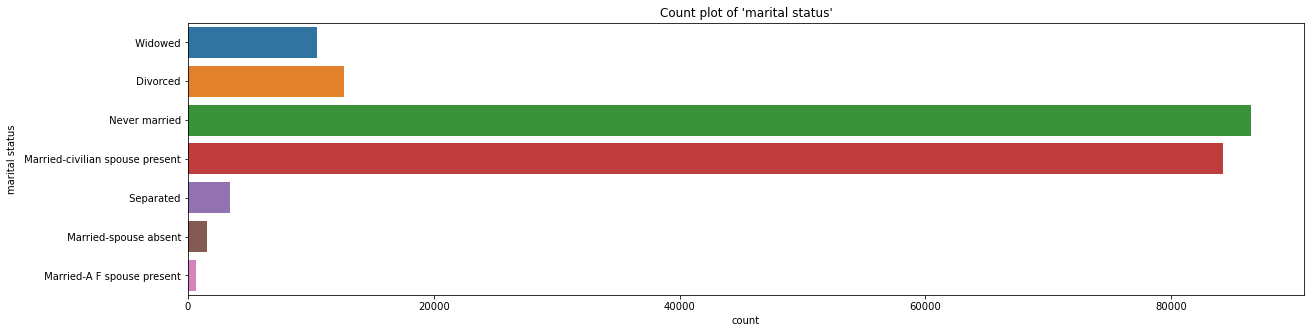

Distribution of the:'major industry code' categories
There are 24 distinct categories
Most common label is ' Not in universe or children' with 50%


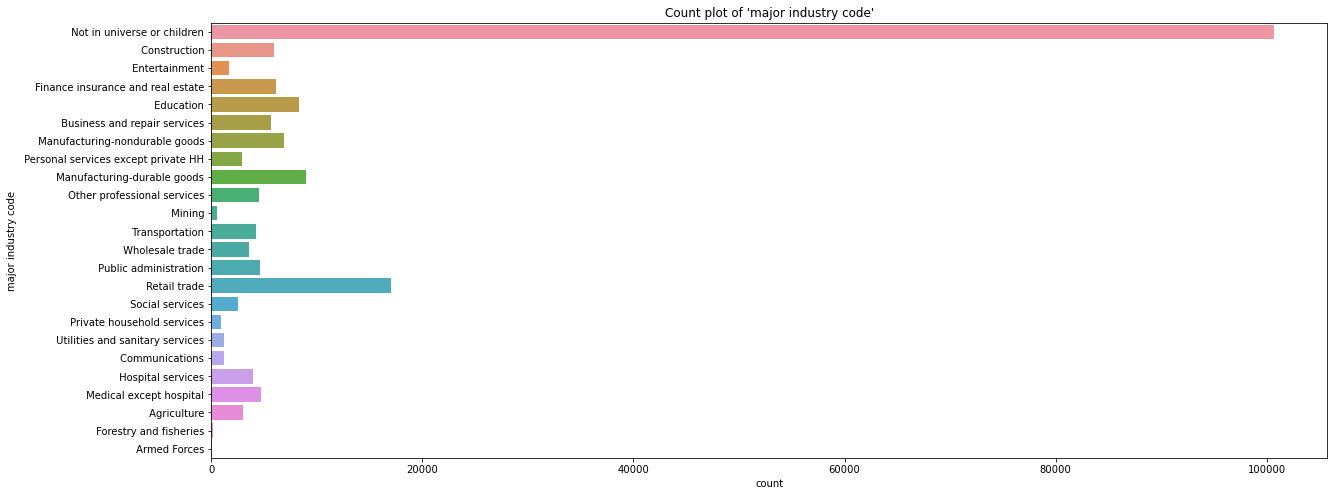

Distribution of the:'major occupation code' categories
There are 15 distinct categories
Most common label is ' Not in universe' with 50%


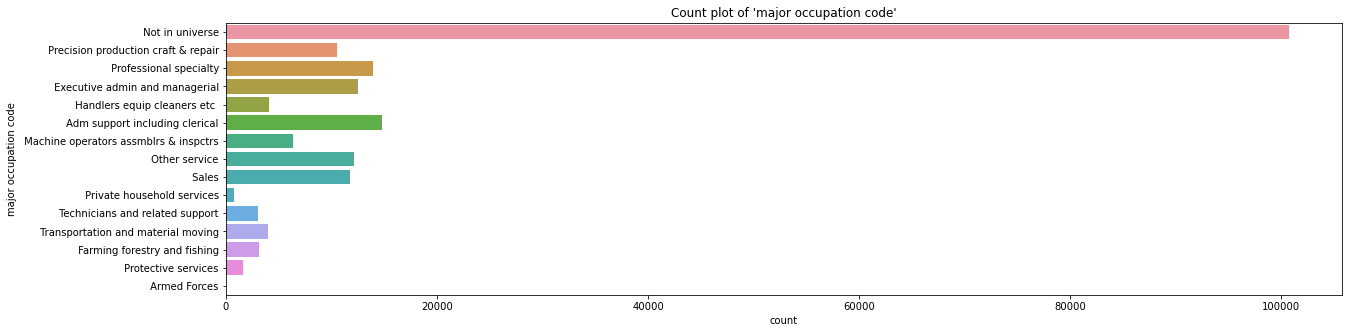

Distribution of the:'race' categories
There are 5 distinct categories
Most common label is ' White' with 84%


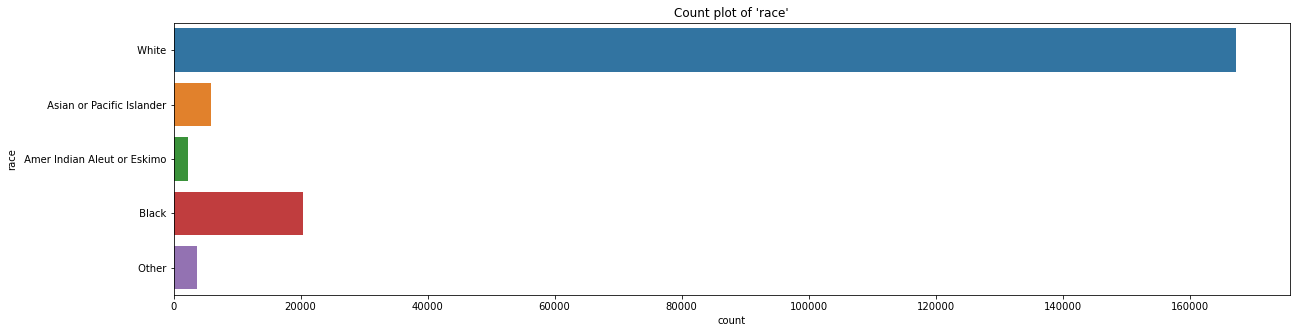

Distribution of the:'hispanic Origin' categories
There are 10 distinct categories
Most common label is ' All other' with 86%


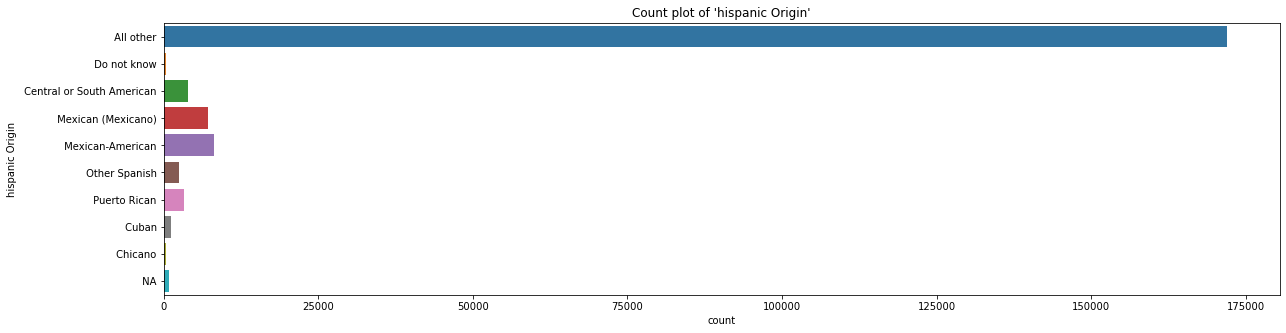

Distribution of the:'sex' categories
There are 2 distinct categories
Most common label is ' Female' with 52%


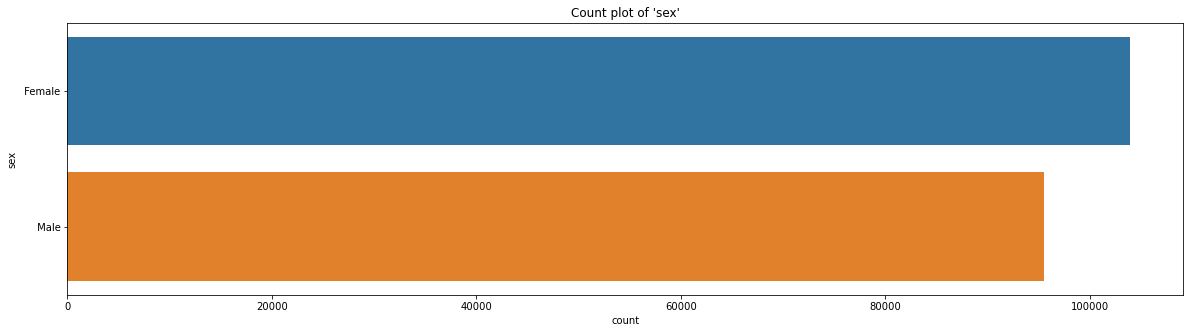

Distribution of the:'member of a labor union' categories
There are 3 distinct categories
Most common label is ' Not in universe' with 90%


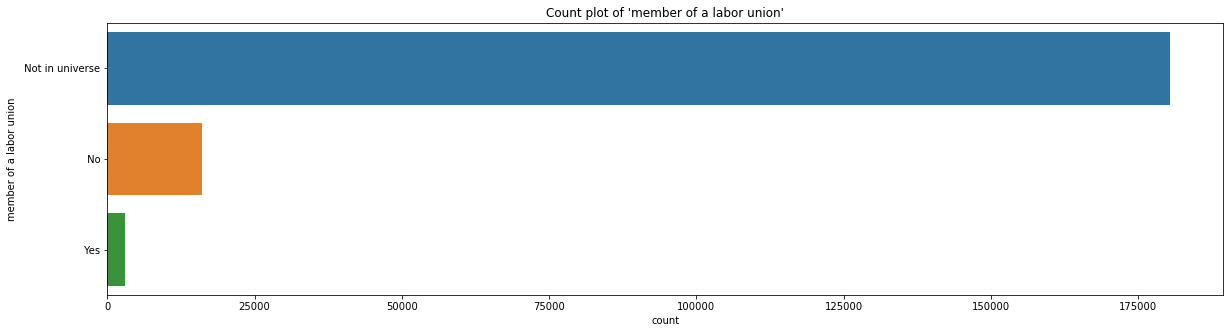

Distribution of the:'reason for unemployment' categories
There are 6 distinct categories
Most common label is ' Not in universe' with 97%


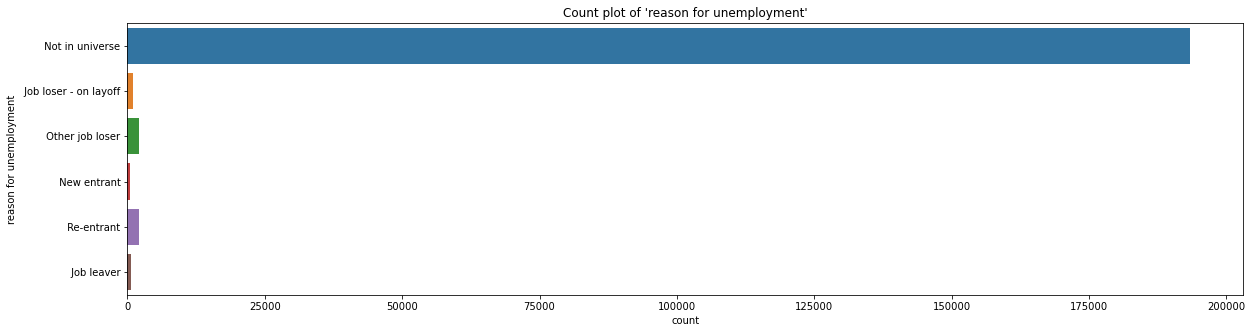

Distribution of the:'full or part time employment stat' categories
There are 8 distinct categories
Most common label is ' Children or Armed Forces' with 62%


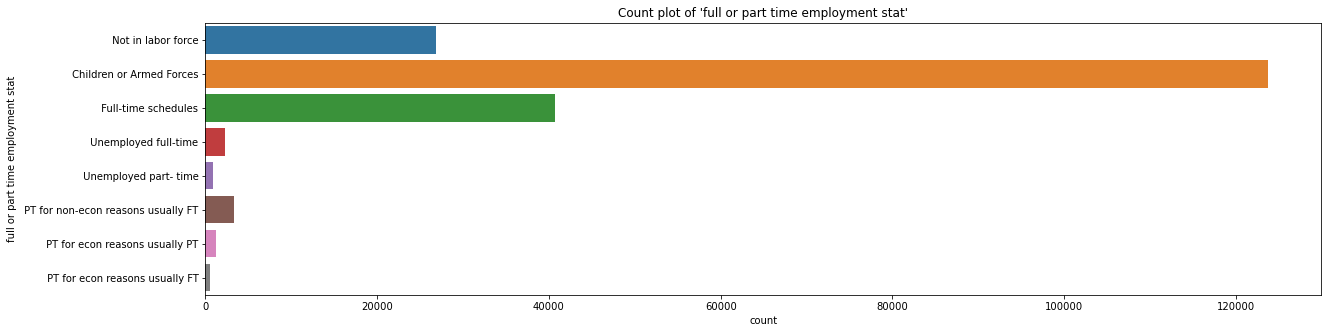

Distribution of the:'tax filer status' categories
There are 6 distinct categories
Most common label is ' Nonfiler' with 38%


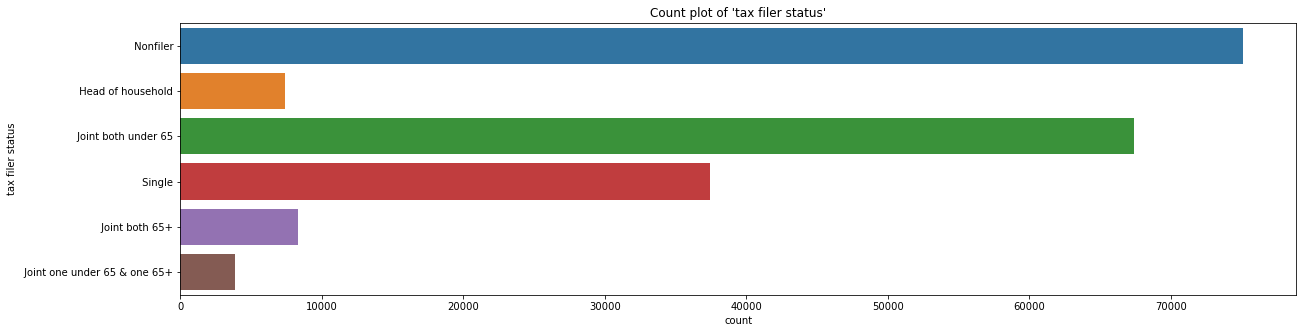

Distribution of the:'region of previous residence' categories
There are 6 distinct categories
Most common label is ' Not in universe' with 92%


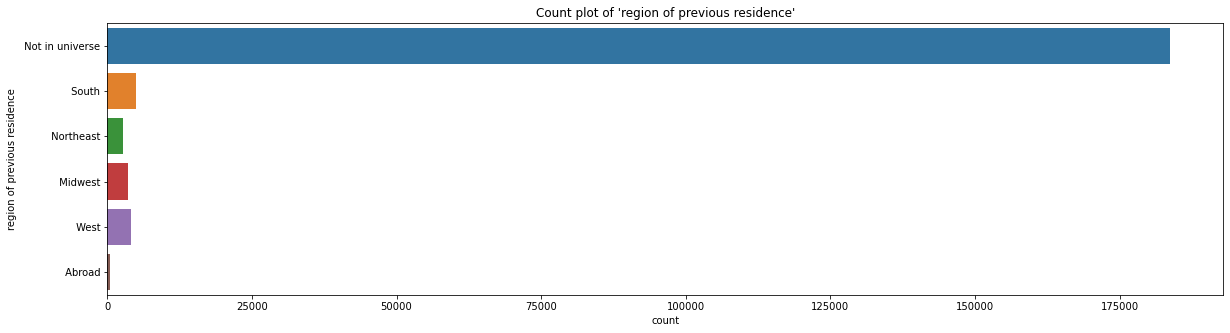

Distribution of the:'state of previous residence' categories
There are 51 distinct categories
Most common label is ' Not in universe' with 92%


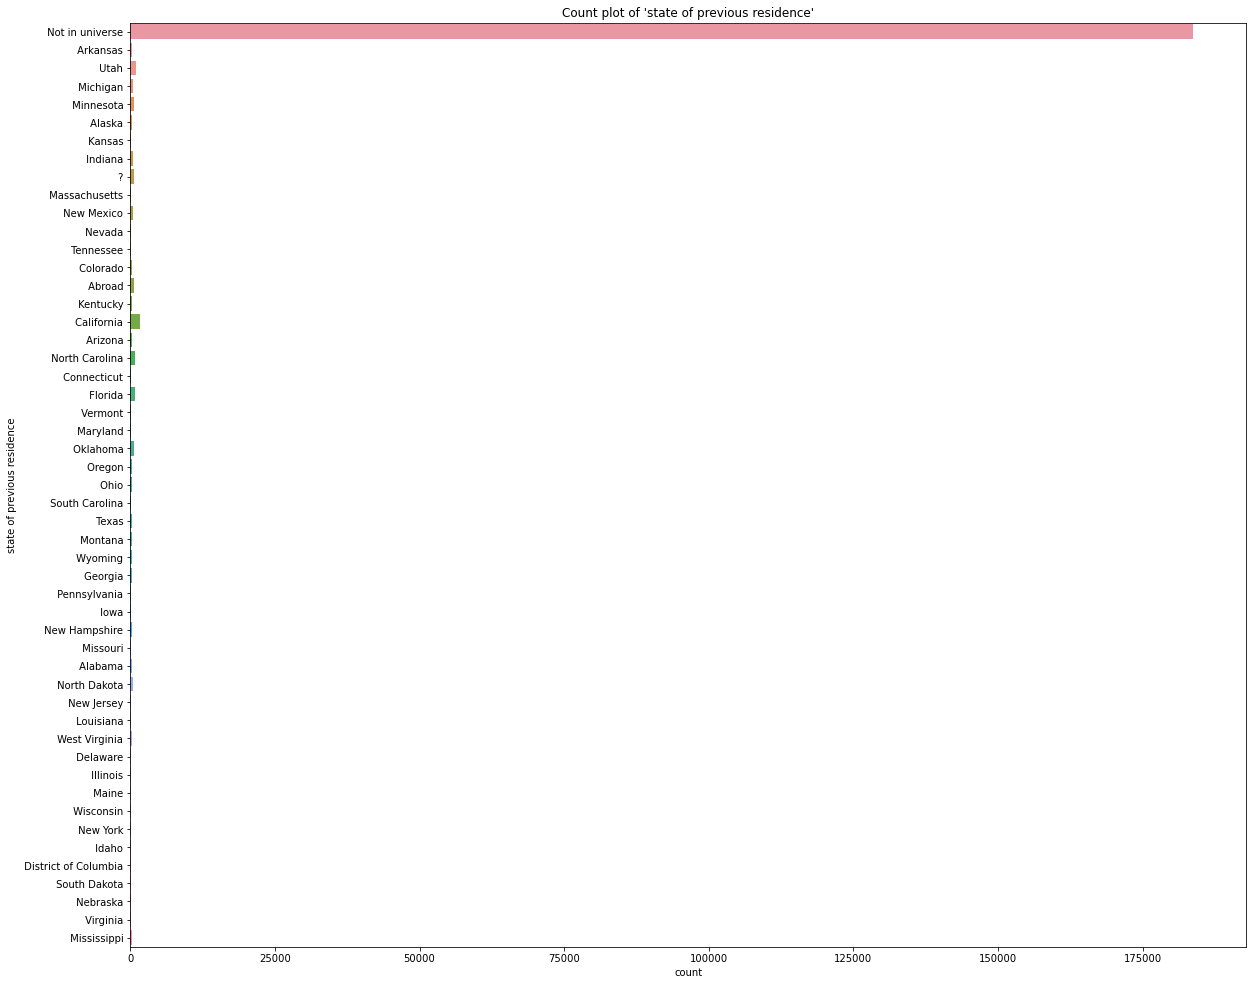

Distribution of the:'detailed household and family stat' categories
There are 38 distinct categories
Most common label is ' Householder' with 27%


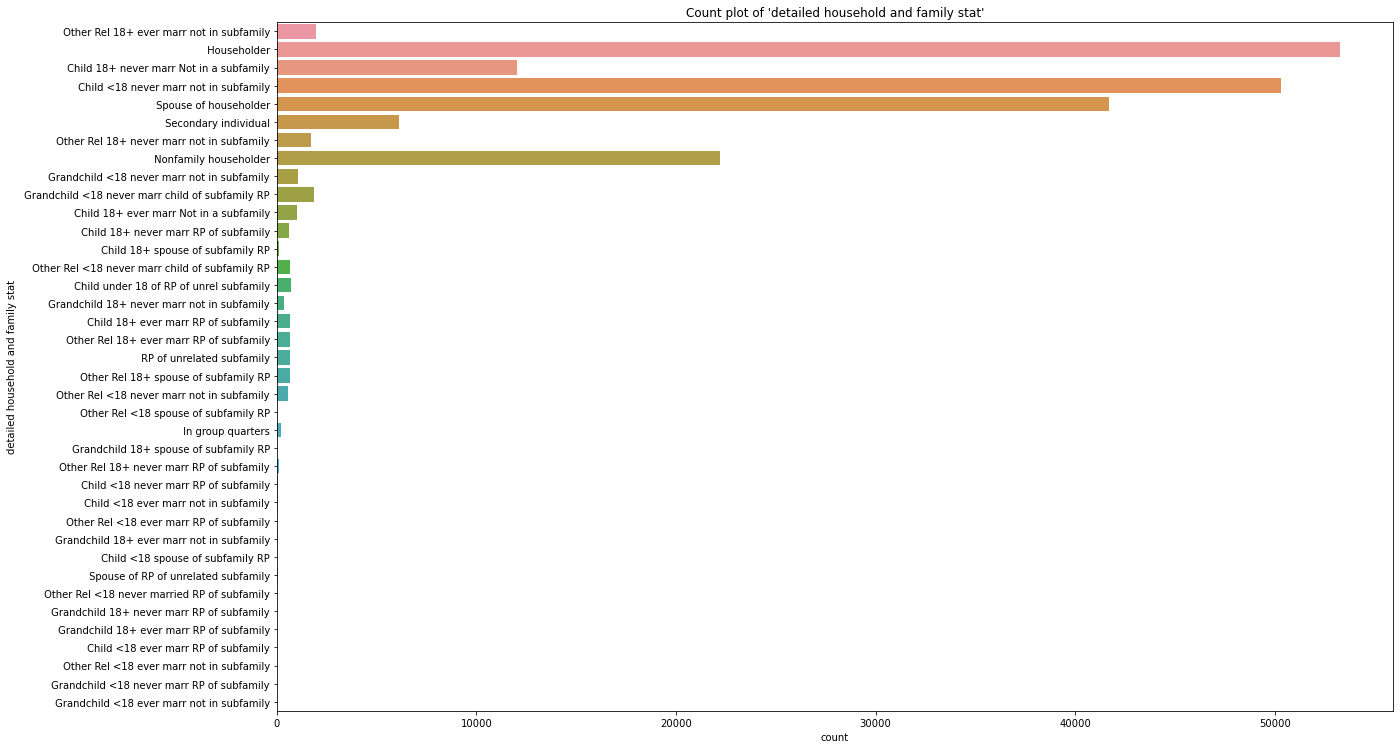

Distribution of the:'detailed household summary in household' categories
There are 8 distinct categories
Most common label is ' Householder' with 38%


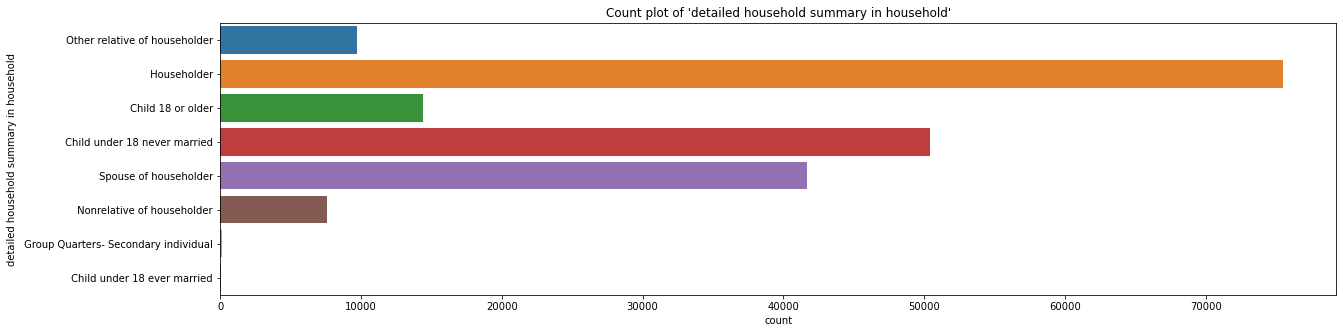

Distribution of the:'migration code-change in msa' categories
There are 10 distinct categories
Most common label is ' ?' with 50%


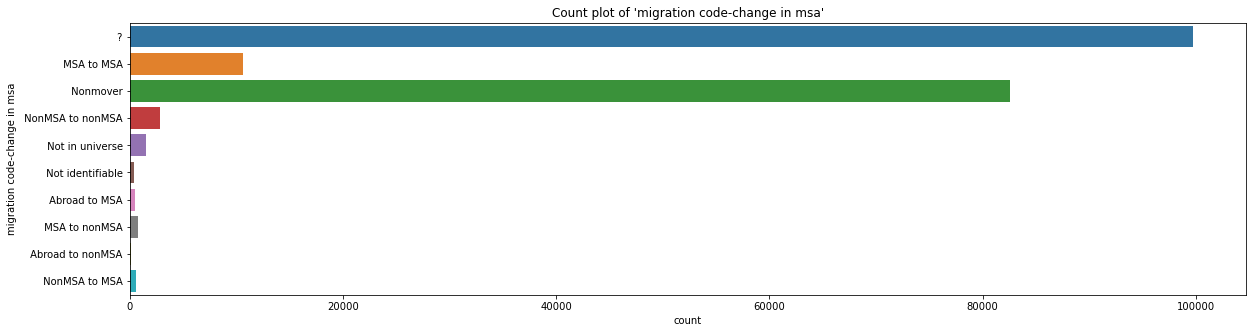

Distribution of the:'migration code-change in reg' categories
There are 9 distinct categories
Most common label is ' ?' with 50%


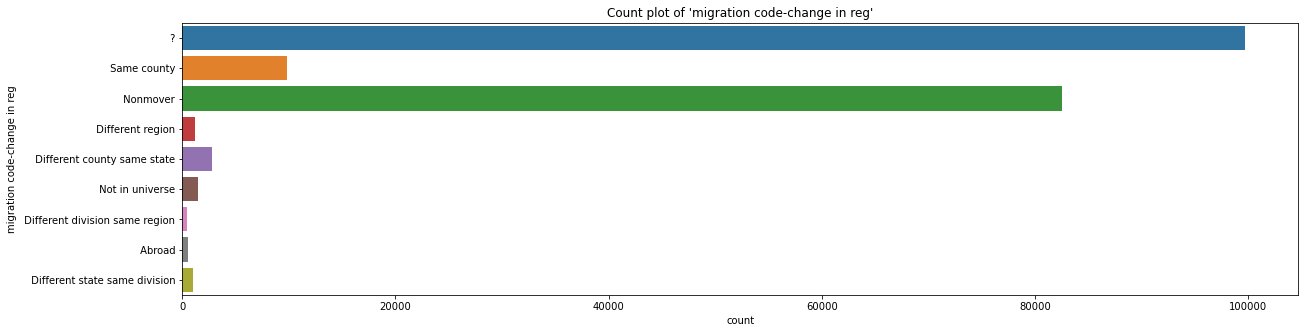

Distribution of the:'migration code-move within reg' categories
There are 10 distinct categories
Most common label is ' ?' with 50%


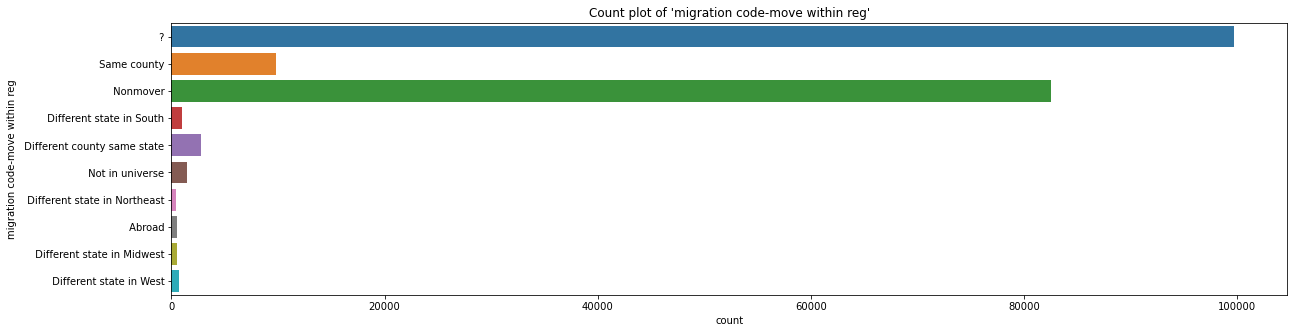

Distribution of the:'live in this house 1 year ago' categories
There are 3 distinct categories
Most common label is ' Not in universe under 1 year old' with 51%


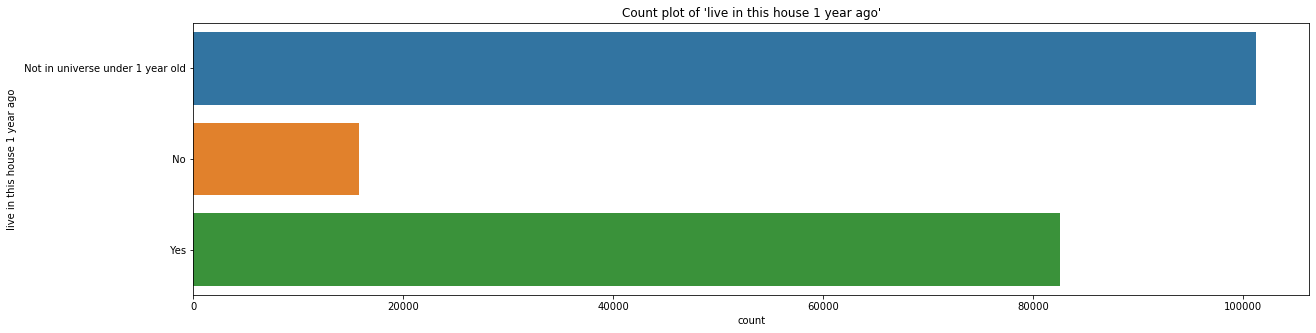

Distribution of the:'migration prev res in sunbelt' categories
There are 4 distinct categories
Most common label is ' ?' with 50%


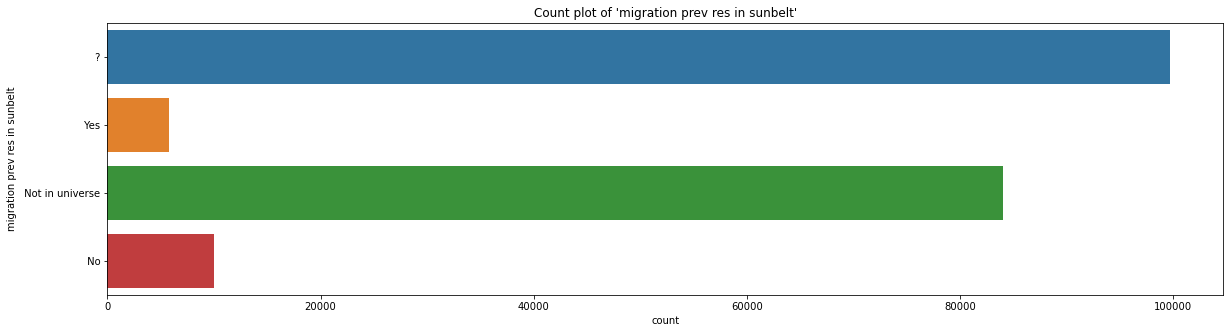

Distribution of the:'family members under 18' categories
There are 5 distinct categories
Most common label is ' Not in universe' with 72%


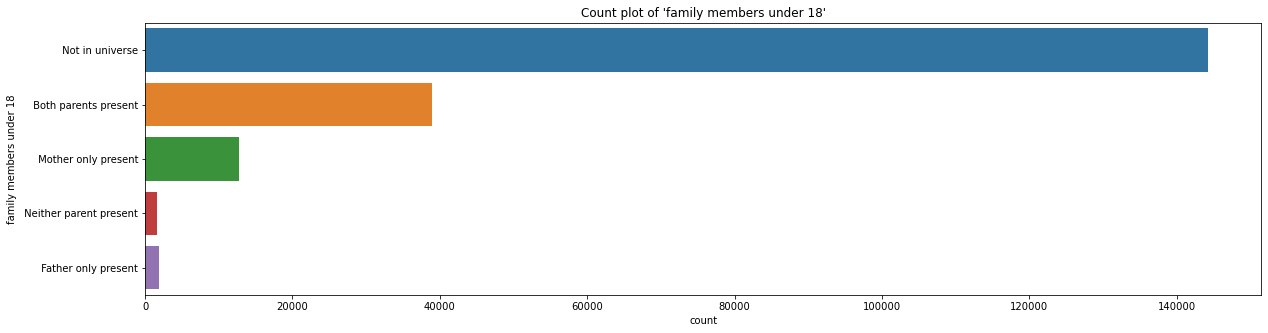

Distribution of the:'country of birth father' categories
There are 43 distinct categories
Most common label is ' United-States' with 80%


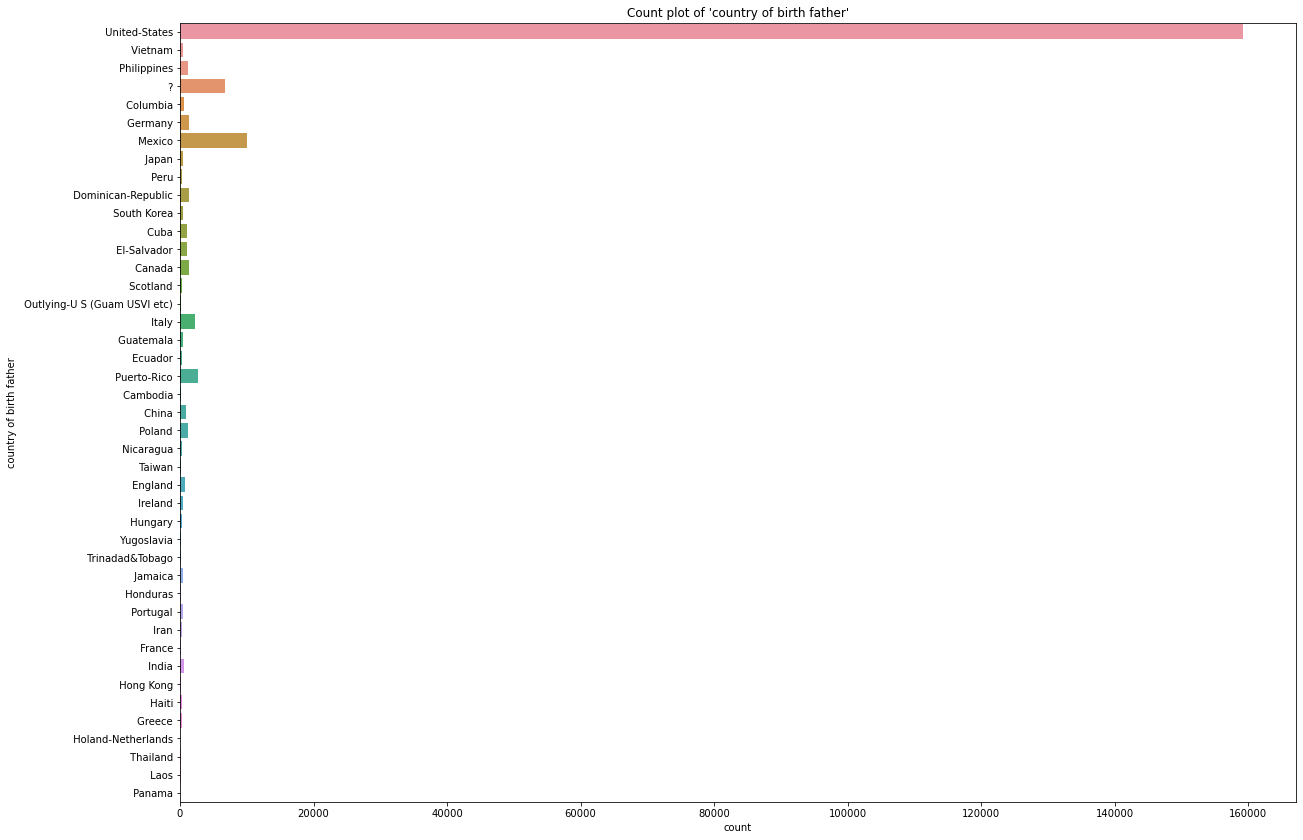

Distribution of the:'country of birth mother' categories
There are 43 distinct categories
Most common label is ' United-States' with 80%


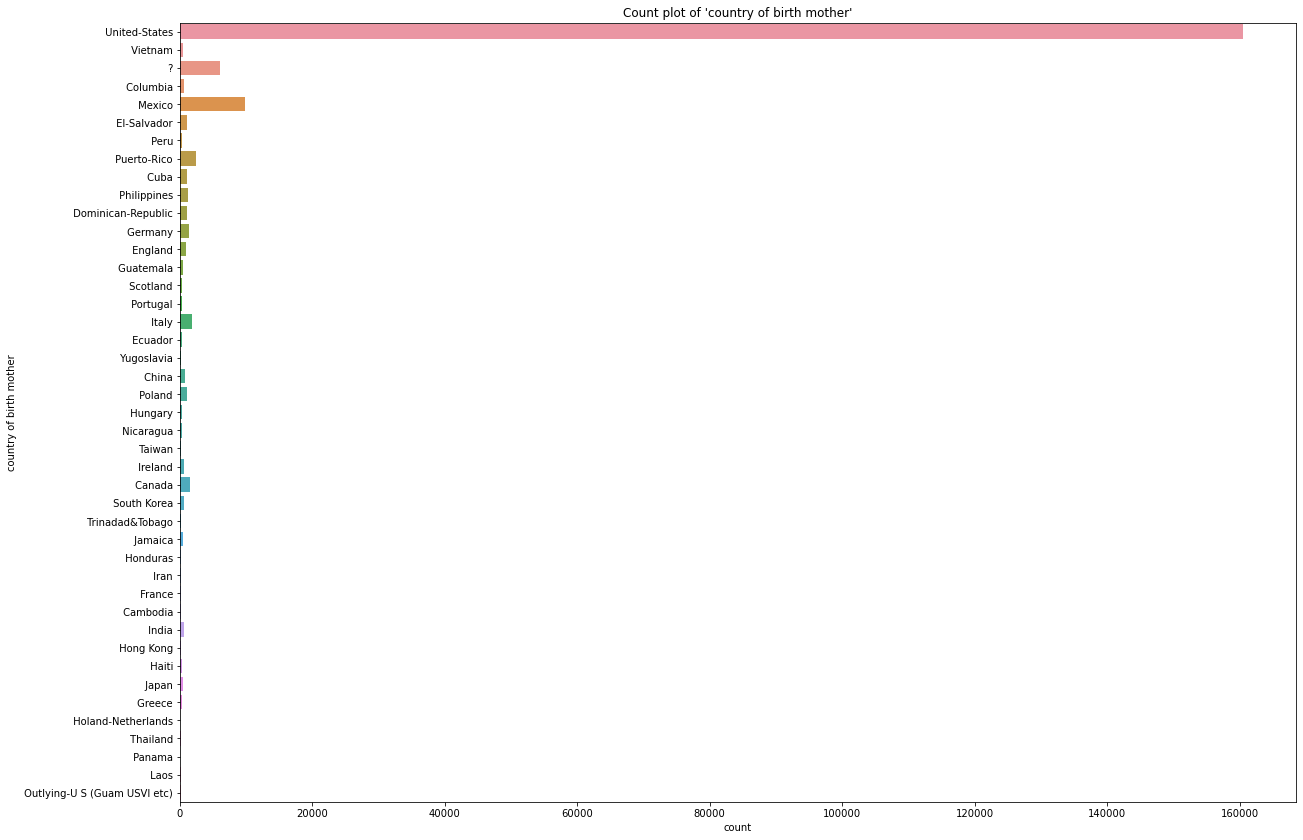

Distribution of the:'country of birth self' categories
There are 43 distinct categories
Most common label is ' United-States' with 89%


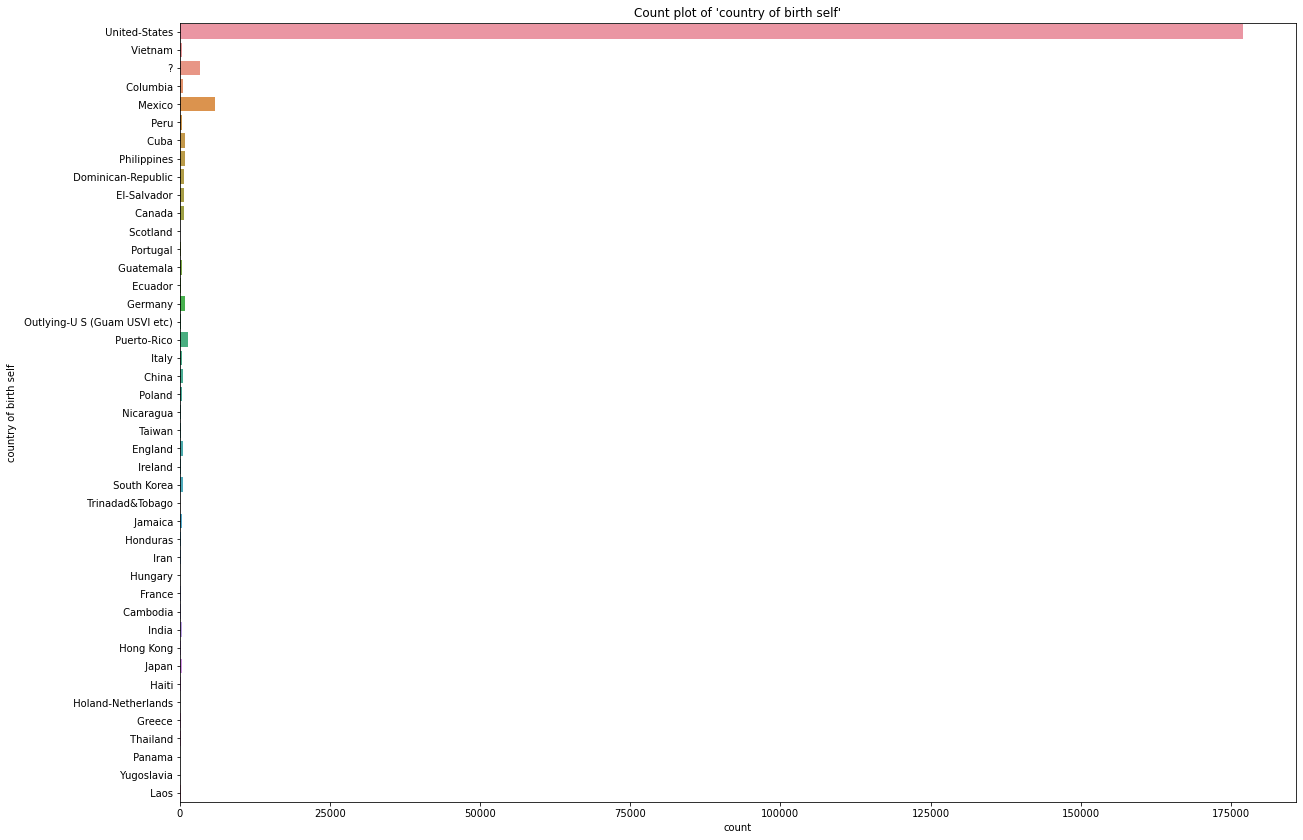

Distribution of the:'citizenship' categories
There are 5 distinct categories
Most common label is ' Native- Born in the United States' with 89%


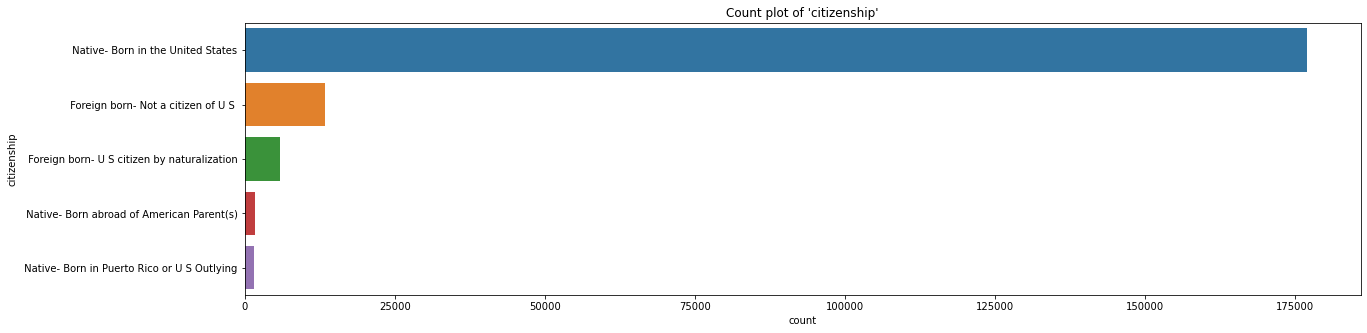

Distribution of the:'own business or self employed' categories
There are 3 distinct categories
Most common label is '0' with 91%


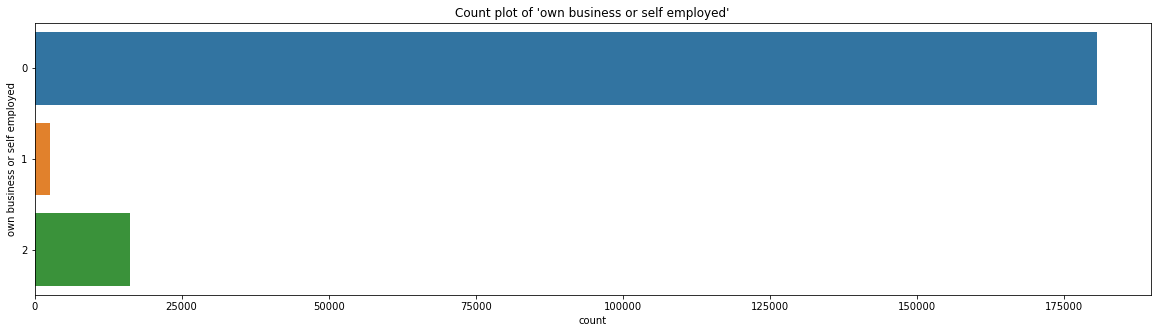

Distribution of the:'fill inc questionnaire for veteran's admin' categories
There are 3 distinct categories
Most common label is ' Not in universe' with 99%


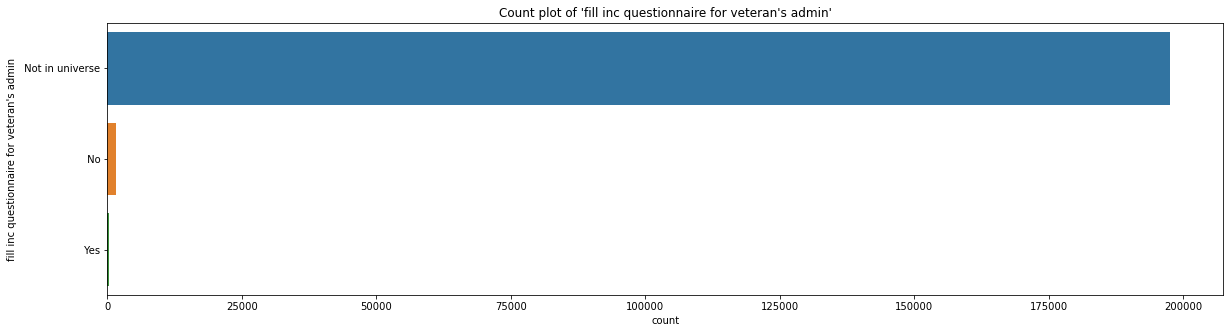

Distribution of the:'veterans benefits' categories
There are 3 distinct categories
Most common label is '2' with 75%


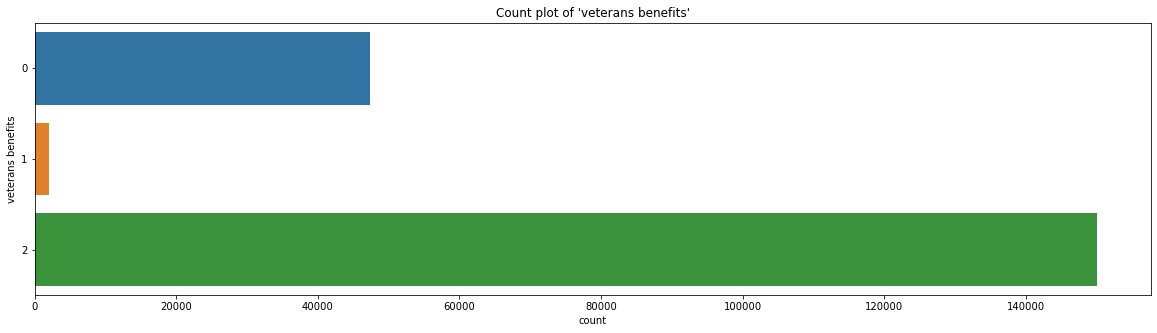

Distribution of the:'year' categories
There are 2 distinct categories
Most common label is '94' with 50%


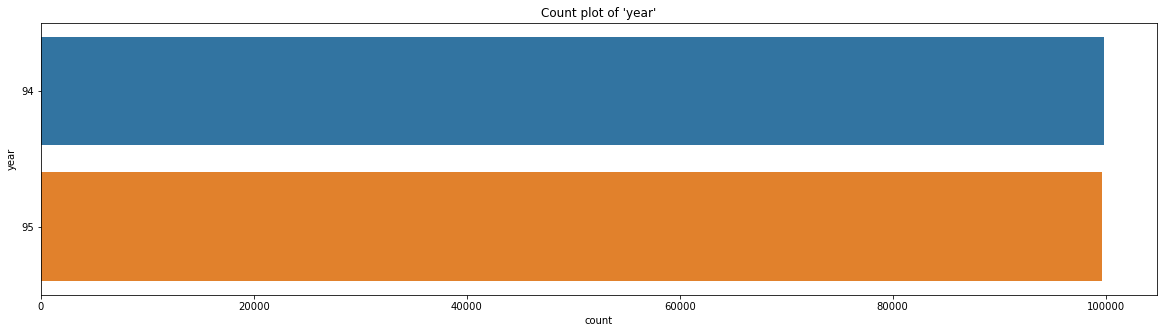

In [13]:
# Display categorical univariate content of each one feature
univariate_categorical_viz(census_learn, categorical_features)

#### Observation
- Vast majority of population either never worked of works in the Private sector
- All data for industry code, major industry code, occupation code, major occupation code all have a mojority (50%) of label '0'
    - According to the metadata, '0' corresponds to Not inunivers/children
    - This distribution can slow down the learning of any meaningful information
- less than 25% of the population has completed higher education
- 84% of the censed population is White which is a little higher then the 80,3% of While americans calculated by the US sensus bureau for 1990.
- There is a skewed towards females (52%) vs males (48%)
- There seems to be a lot of missing data form all the migration features, as the majority (>50%) label is '?'
- Most of the population in born in the US, has citizenship and parents born in the US

The label distribution for most features is unbalanced and should be taken into consideration. </br>

There are sets of features that seem correlated such as the migration features, nationality feature or occupation/idustry. It would be interesting to consider combining them into one main feature to reduce dimentionality. </br> 

In general, most of the features here apply to a small portion of the population making a significant portion on the data default values.

#### Key takeaway
- There are many useful features but they will need work before being used in a model.
- To counteract the unbalanced distribution of labels, sampling methodes could be used.
- As some features seem to be dependant, dimention reduction could be applied to reduce the feature space even further.


### 1.3.2. Bivariate study of categorical features
#### Objective
- Visualize the distribution of the taget label with respect to the labels of each feature.
- We will use a barplot adding the target feature as hue.

Comparing 'class of worker' feature with the target 'income classification'


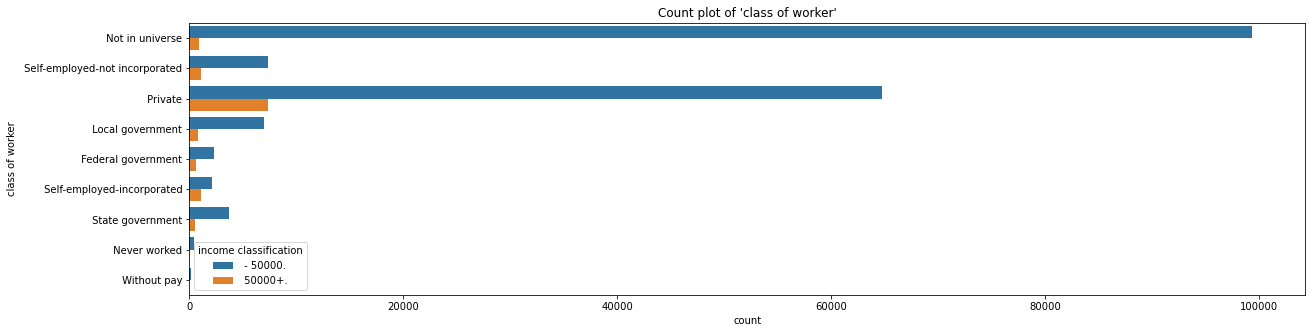

Comparing 'industry code' feature with the target 'income classification'


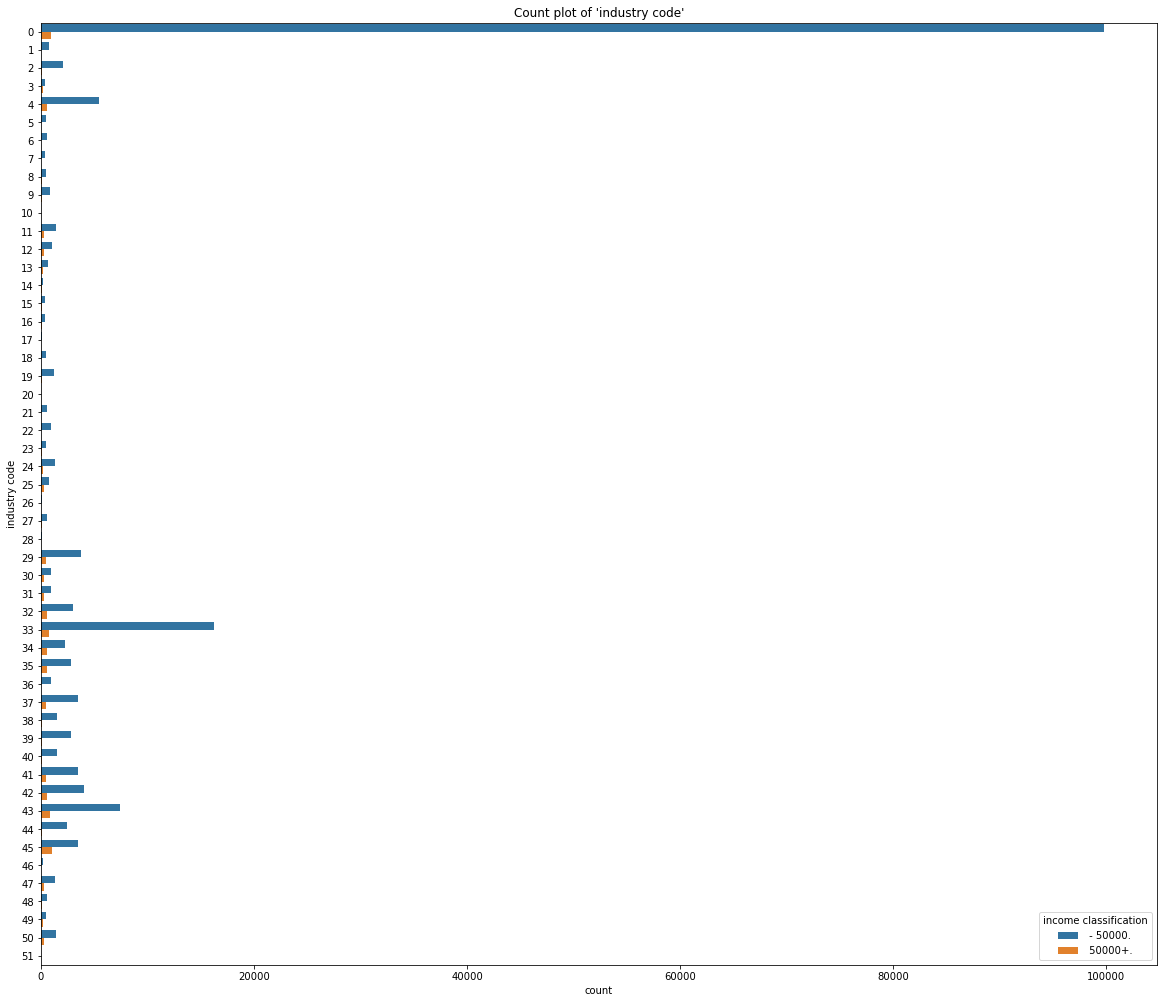

Comparing 'occupation code' feature with the target 'income classification'


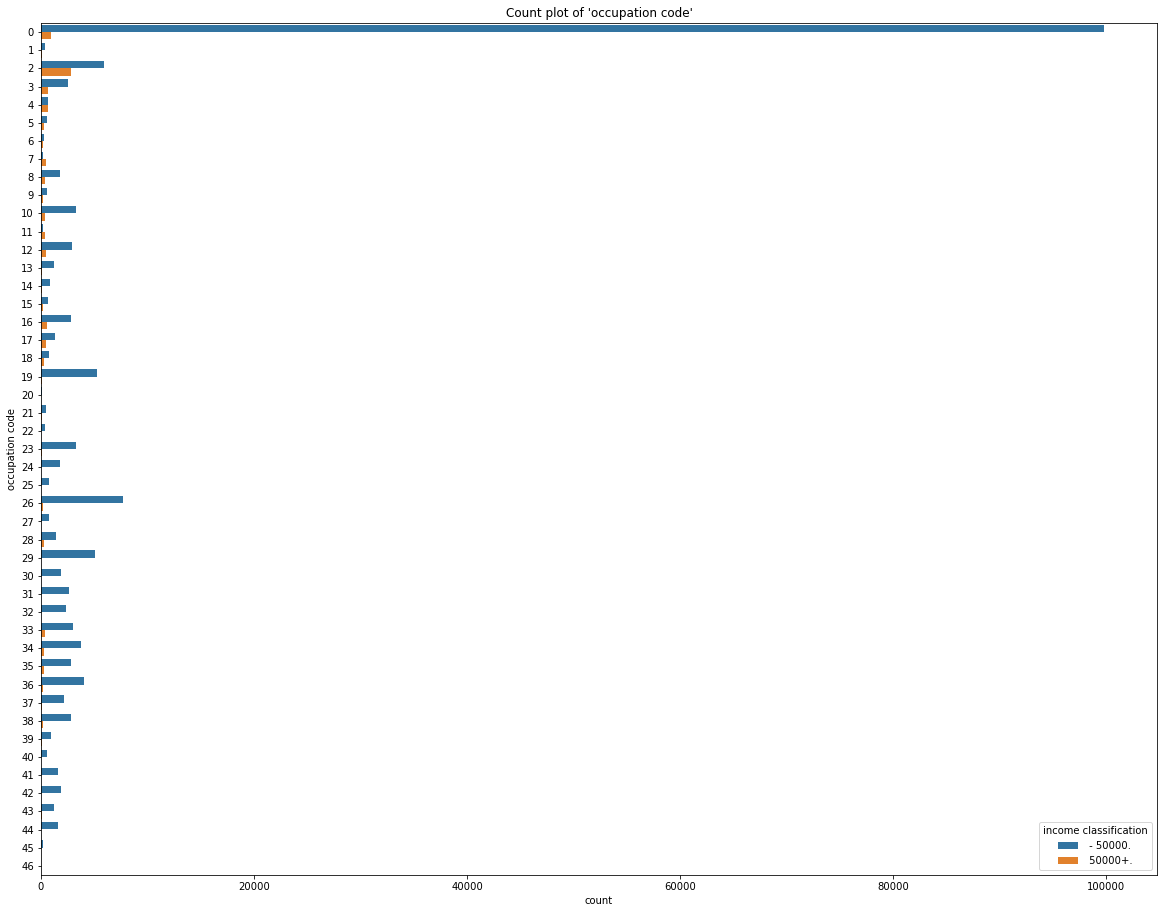

Comparing 'education' feature with the target 'income classification'


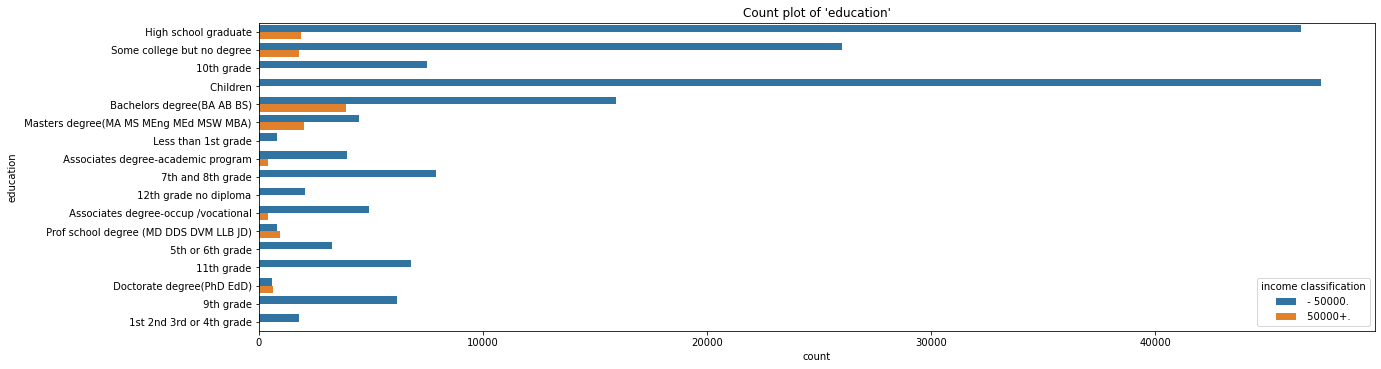

Comparing 'enrolled in edu inst last wk' feature with the target 'income classification'


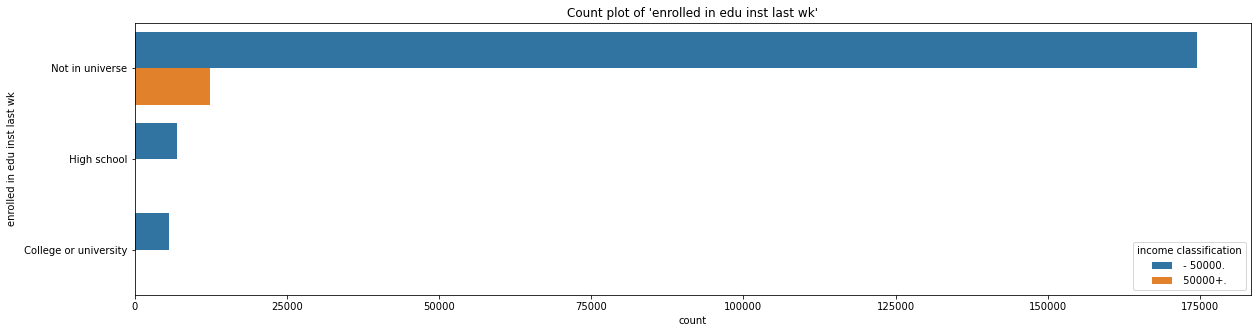

Comparing 'marital status' feature with the target 'income classification'


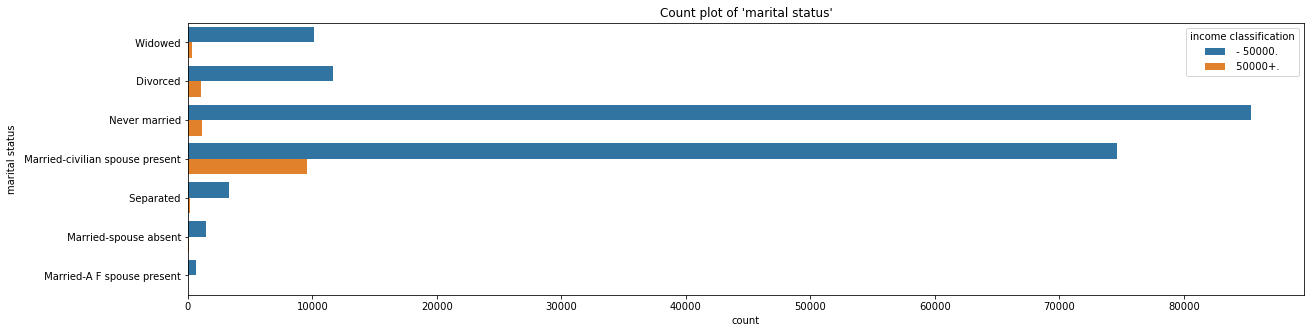

Comparing 'major industry code' feature with the target 'income classification'


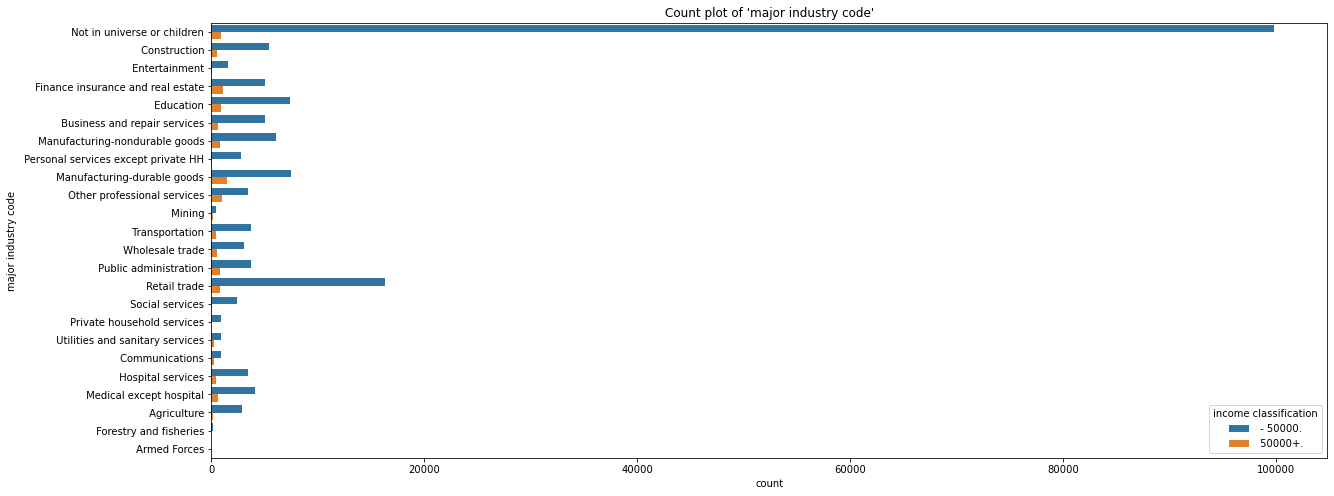

Comparing 'major occupation code' feature with the target 'income classification'


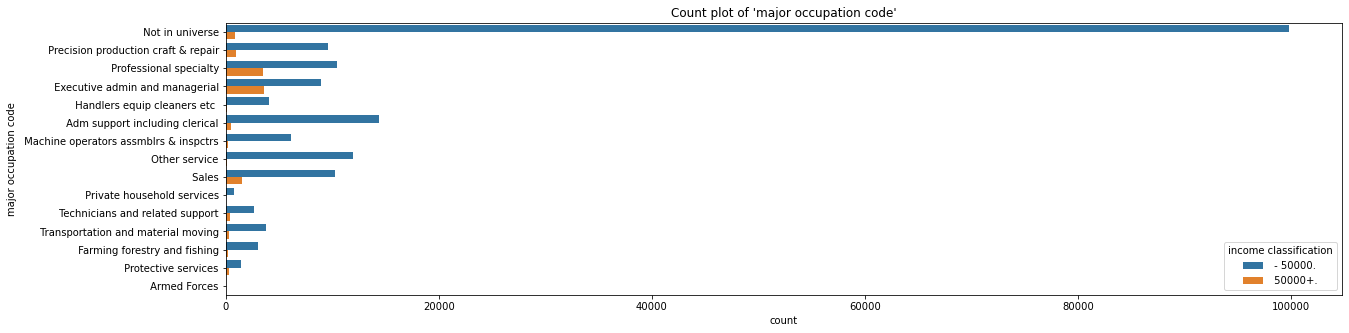

Comparing 'race' feature with the target 'income classification'


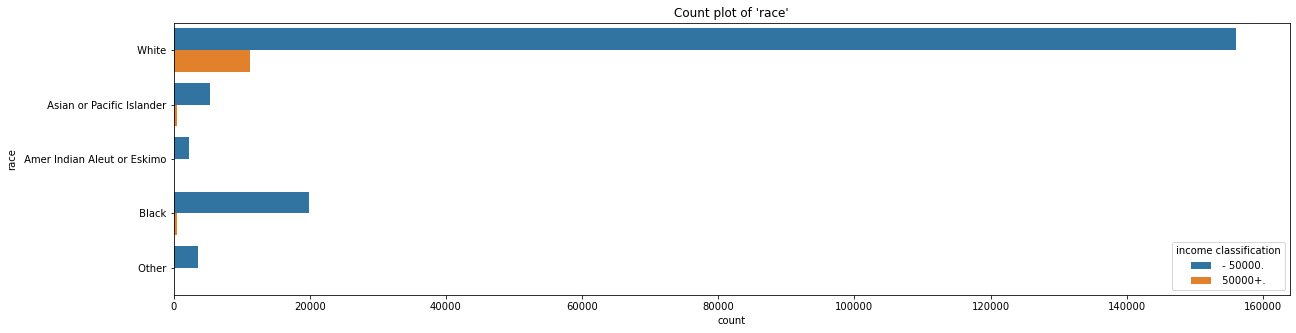

Comparing 'hispanic Origin' feature with the target 'income classification'


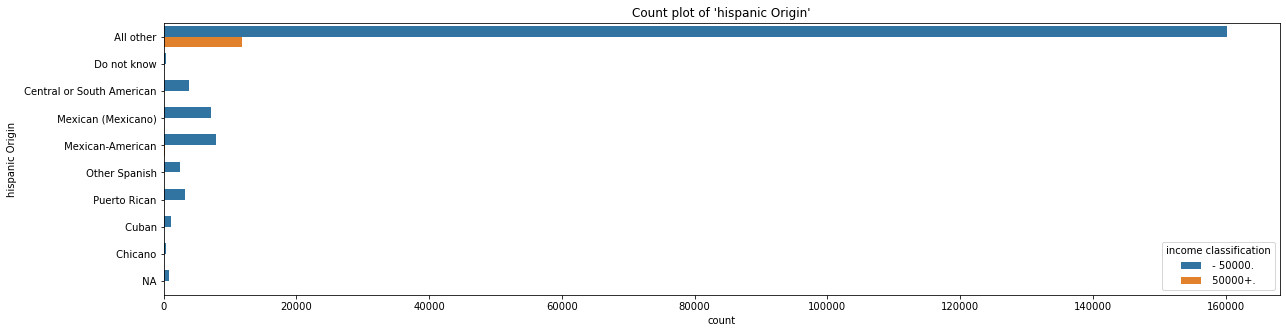

Comparing 'sex' feature with the target 'income classification'


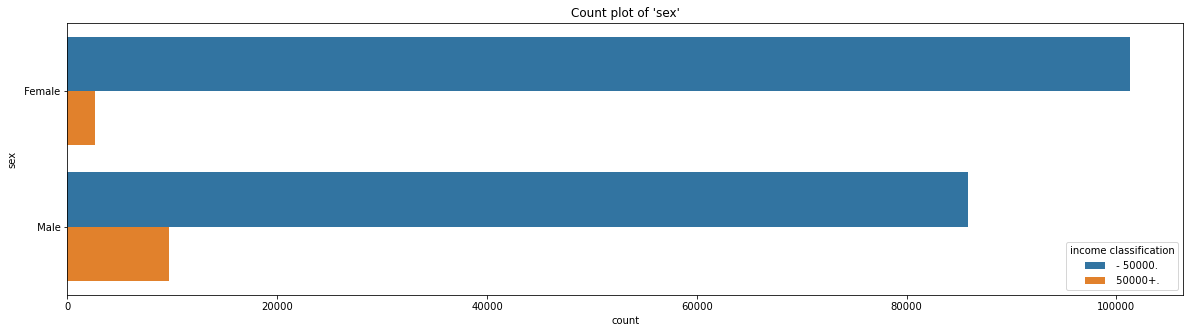

Comparing 'member of a labor union' feature with the target 'income classification'


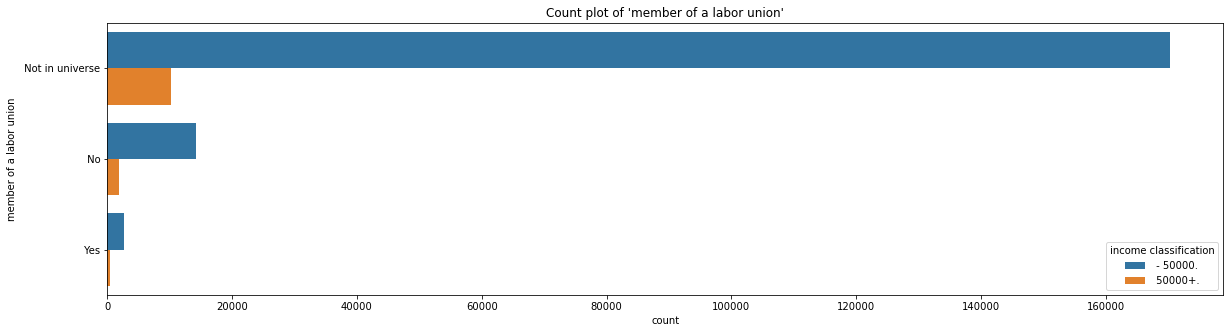

Comparing 'reason for unemployment' feature with the target 'income classification'


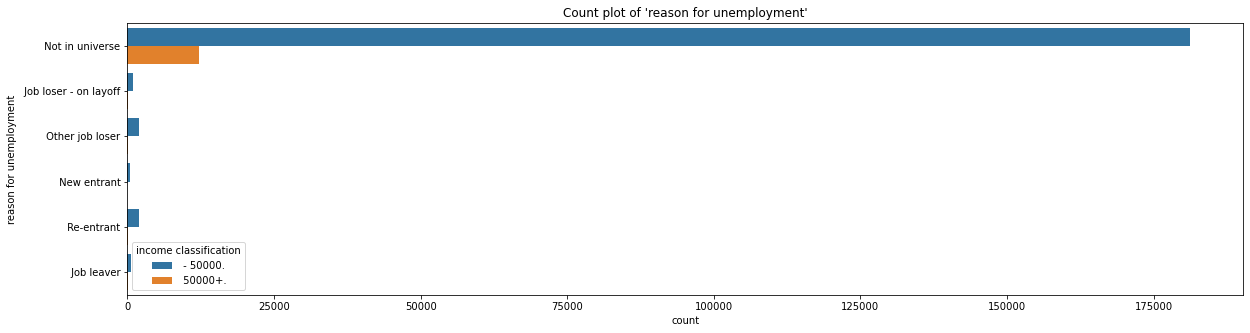

Comparing 'full or part time employment stat' feature with the target 'income classification'


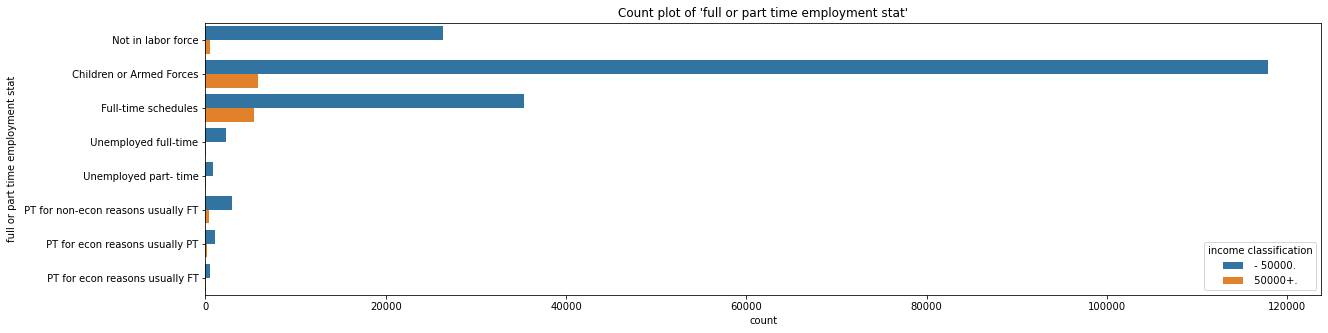

Comparing 'tax filer status' feature with the target 'income classification'


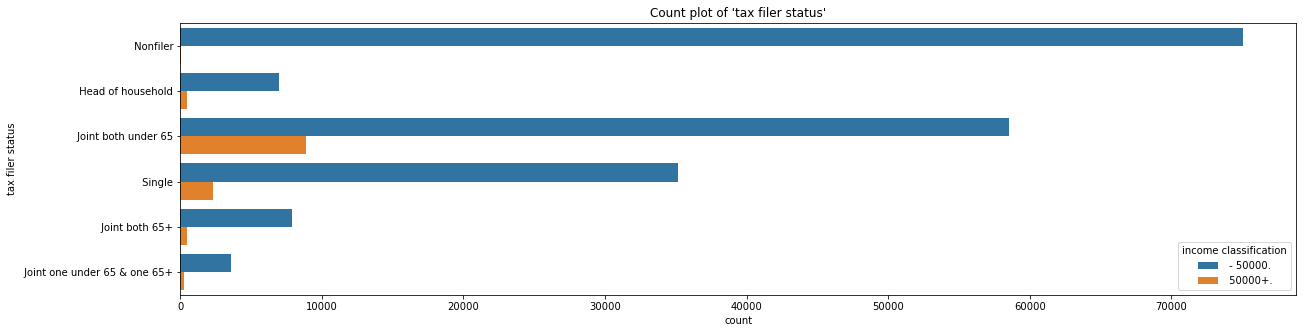

Comparing 'region of previous residence' feature with the target 'income classification'


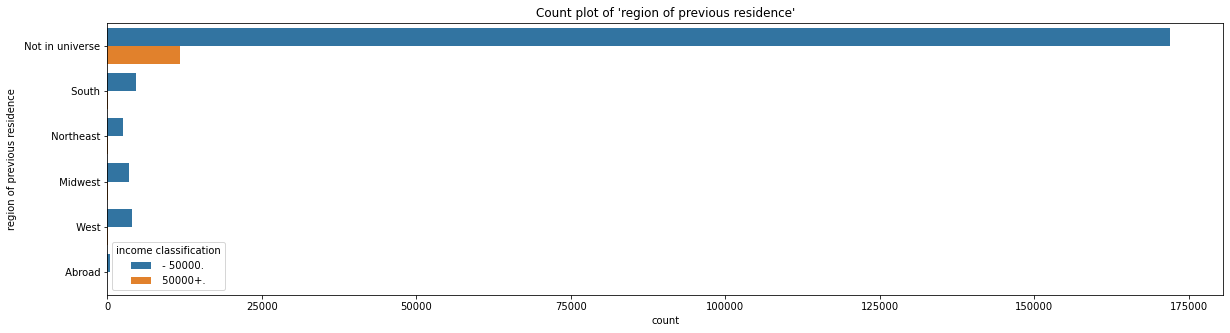

Comparing 'state of previous residence' feature with the target 'income classification'


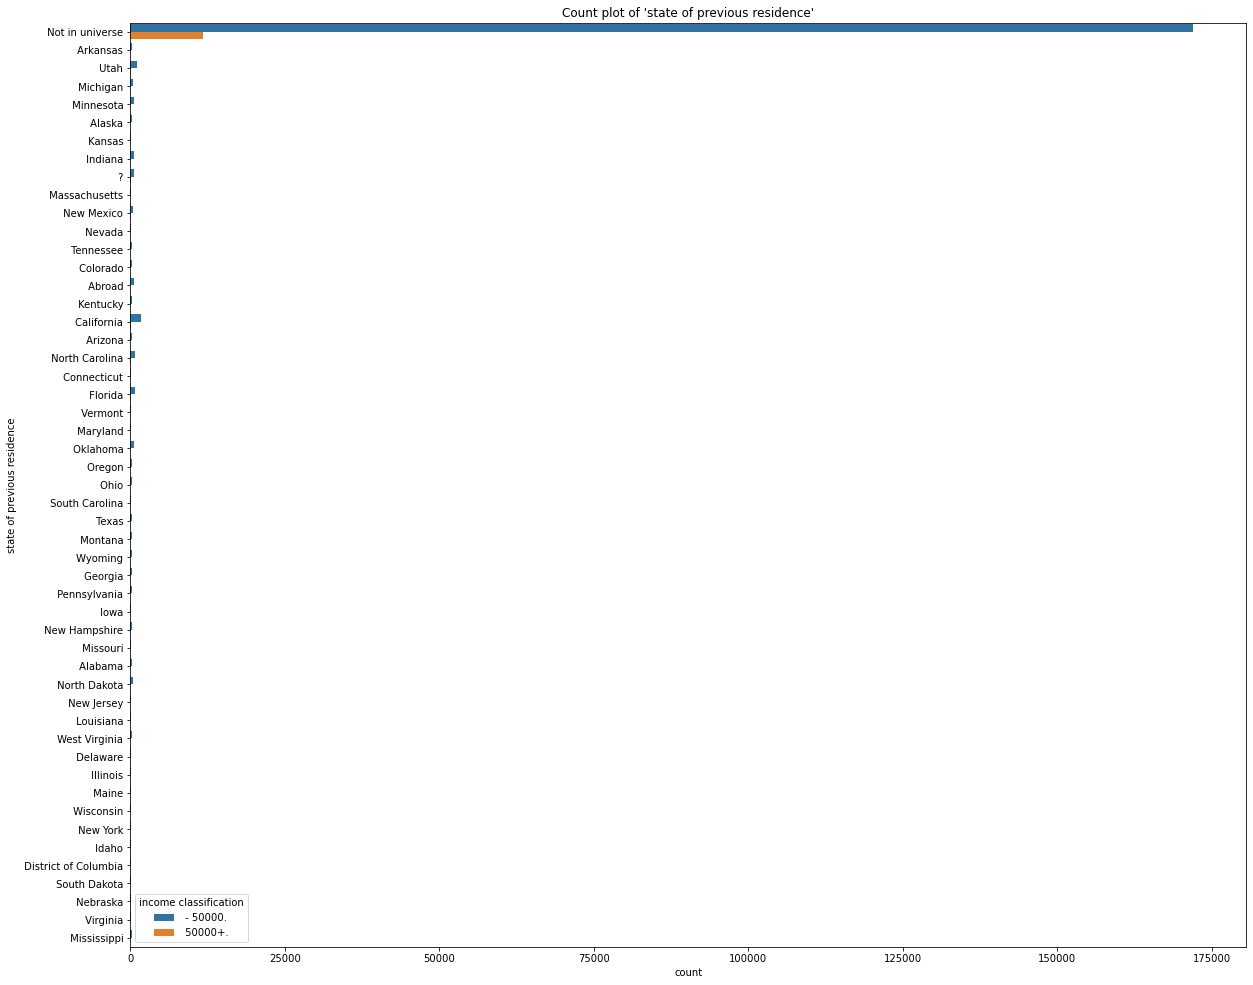

Comparing 'detailed household and family stat' feature with the target 'income classification'


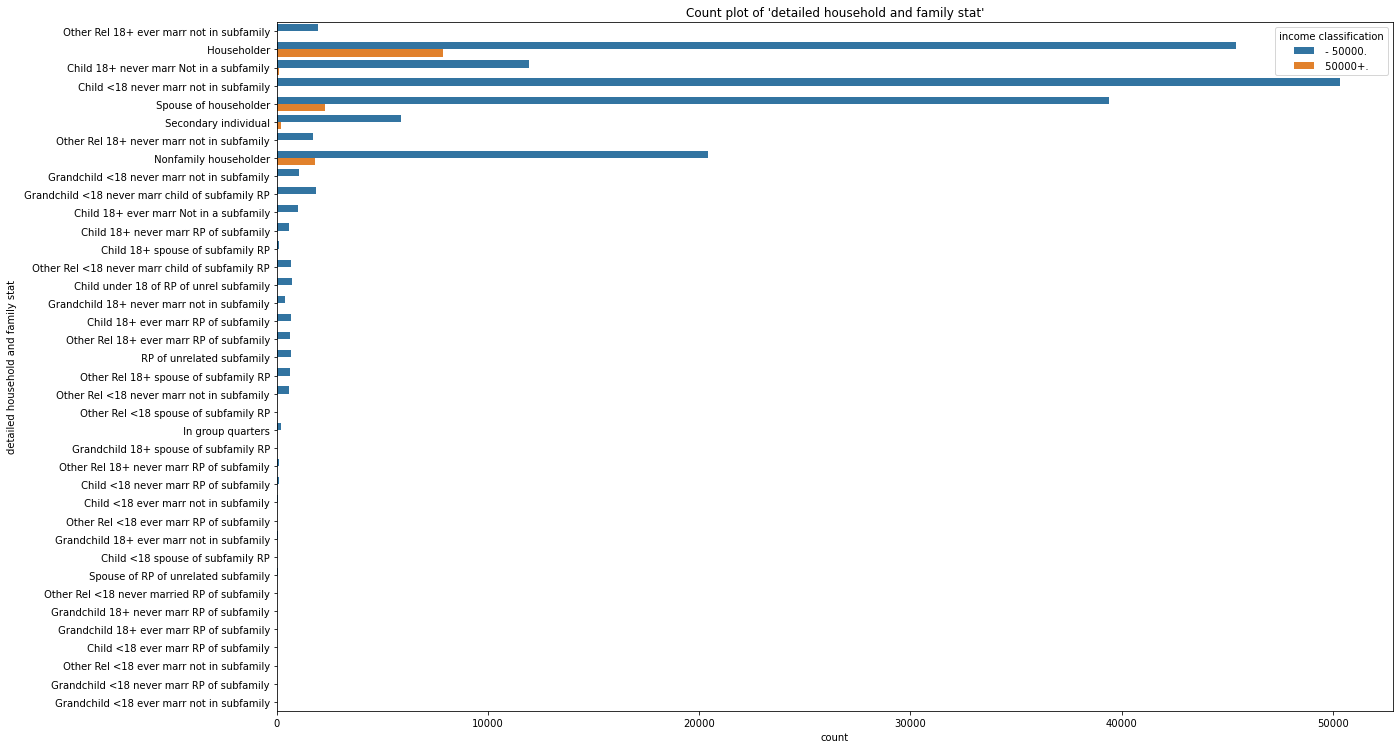

Comparing 'detailed household summary in household' feature with the target 'income classification'


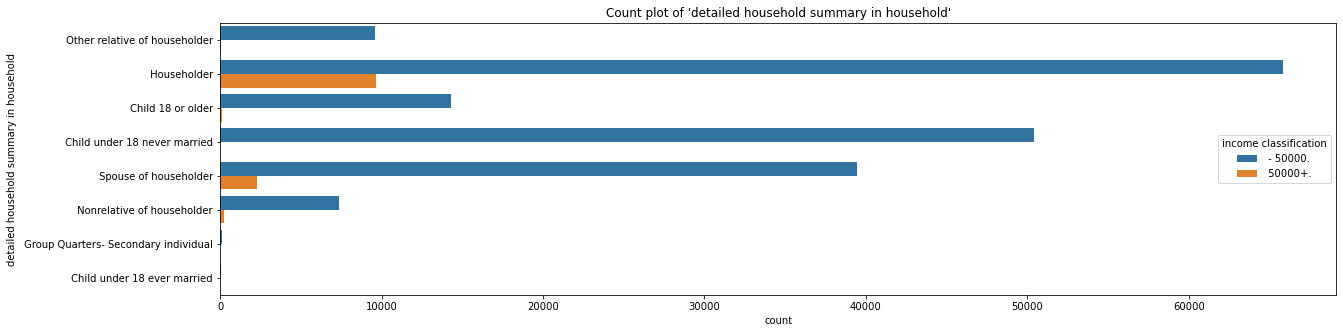

Comparing 'migration code-change in msa' feature with the target 'income classification'


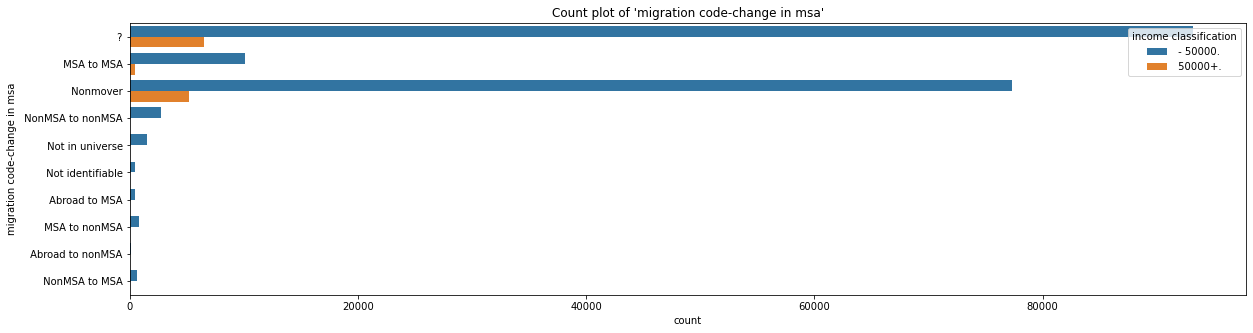

Comparing 'migration code-change in reg' feature with the target 'income classification'


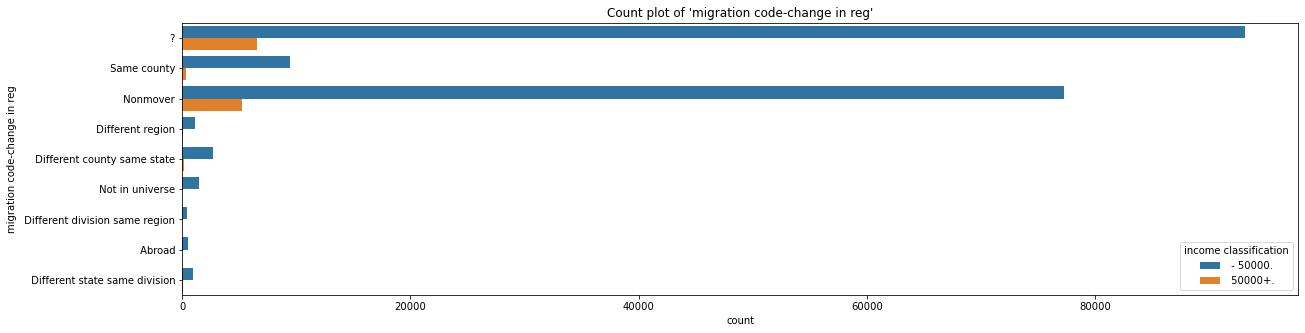

Comparing 'migration code-move within reg' feature with the target 'income classification'


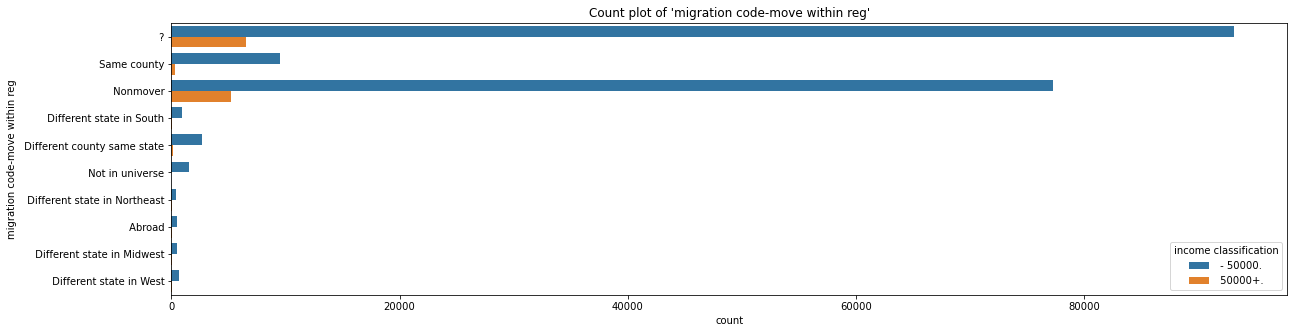

Comparing 'live in this house 1 year ago' feature with the target 'income classification'


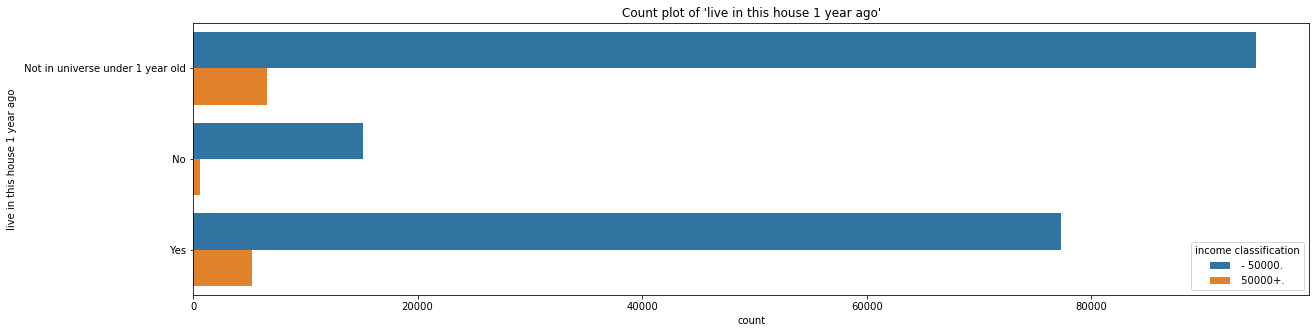

Comparing 'migration prev res in sunbelt' feature with the target 'income classification'


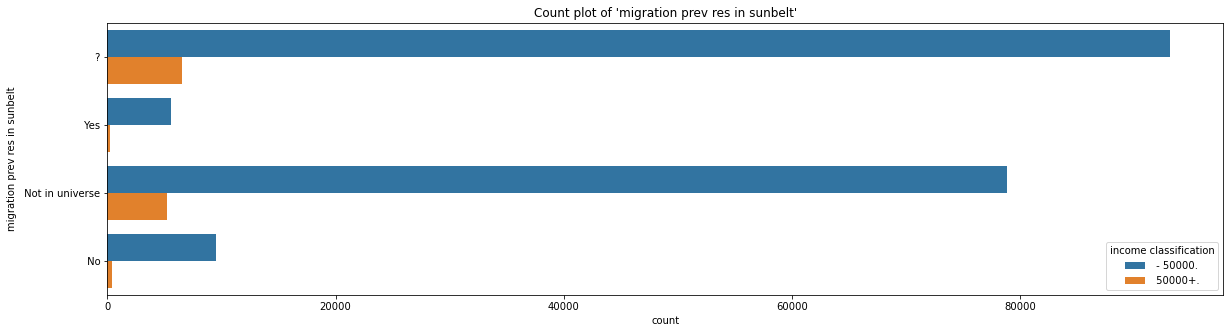

Comparing 'family members under 18' feature with the target 'income classification'


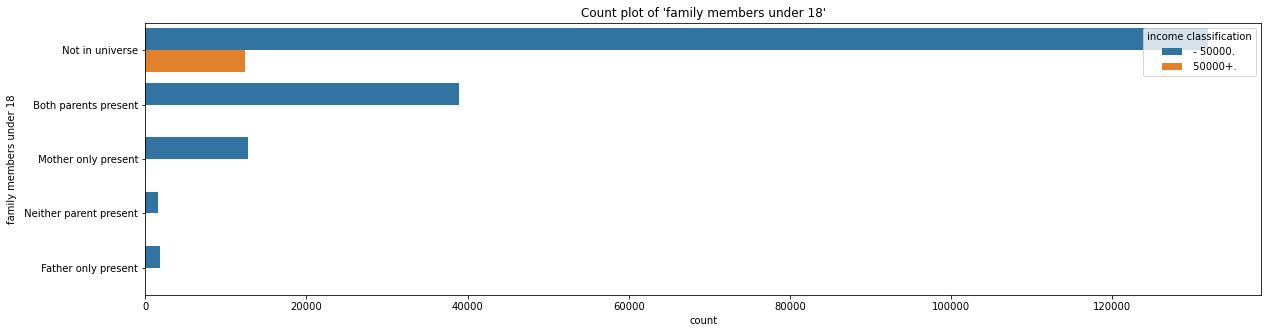

Comparing 'country of birth father' feature with the target 'income classification'


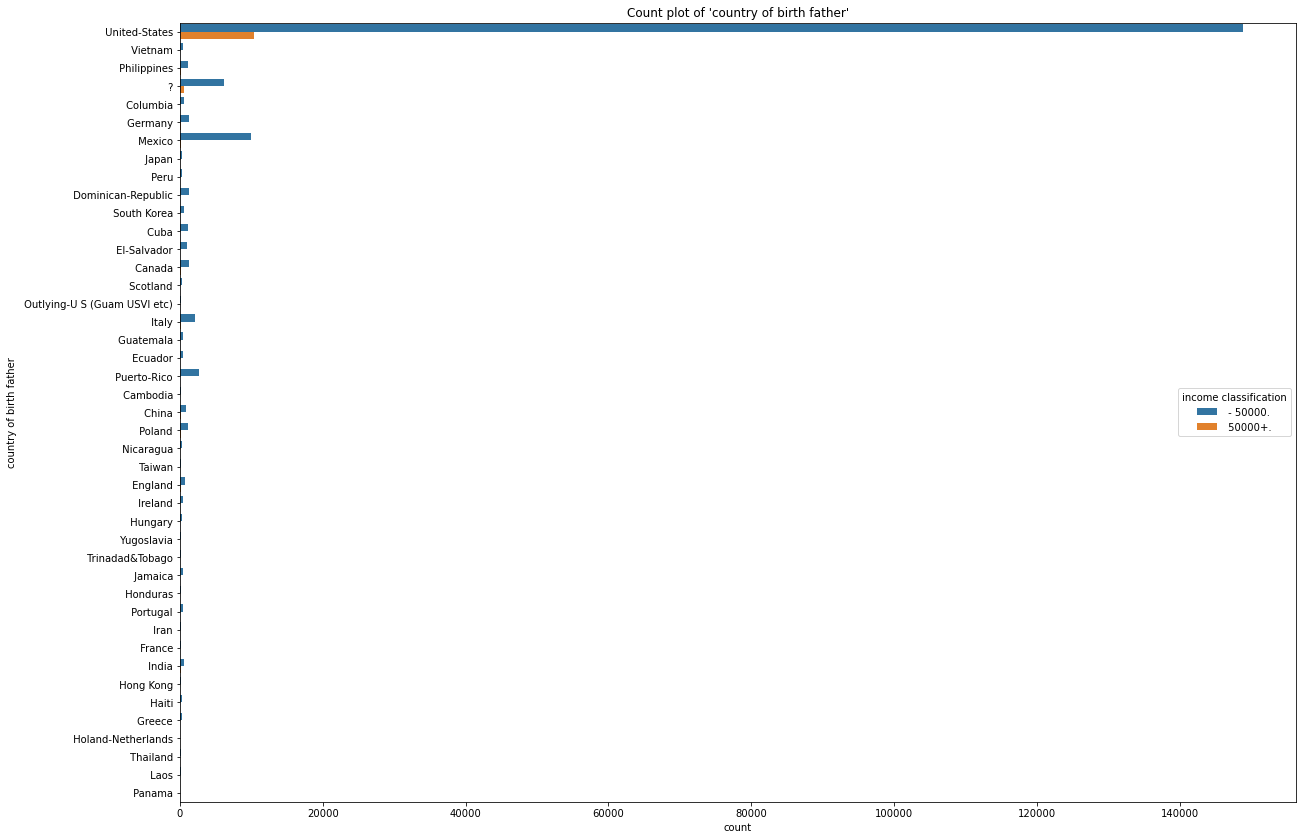

Comparing 'country of birth mother' feature with the target 'income classification'


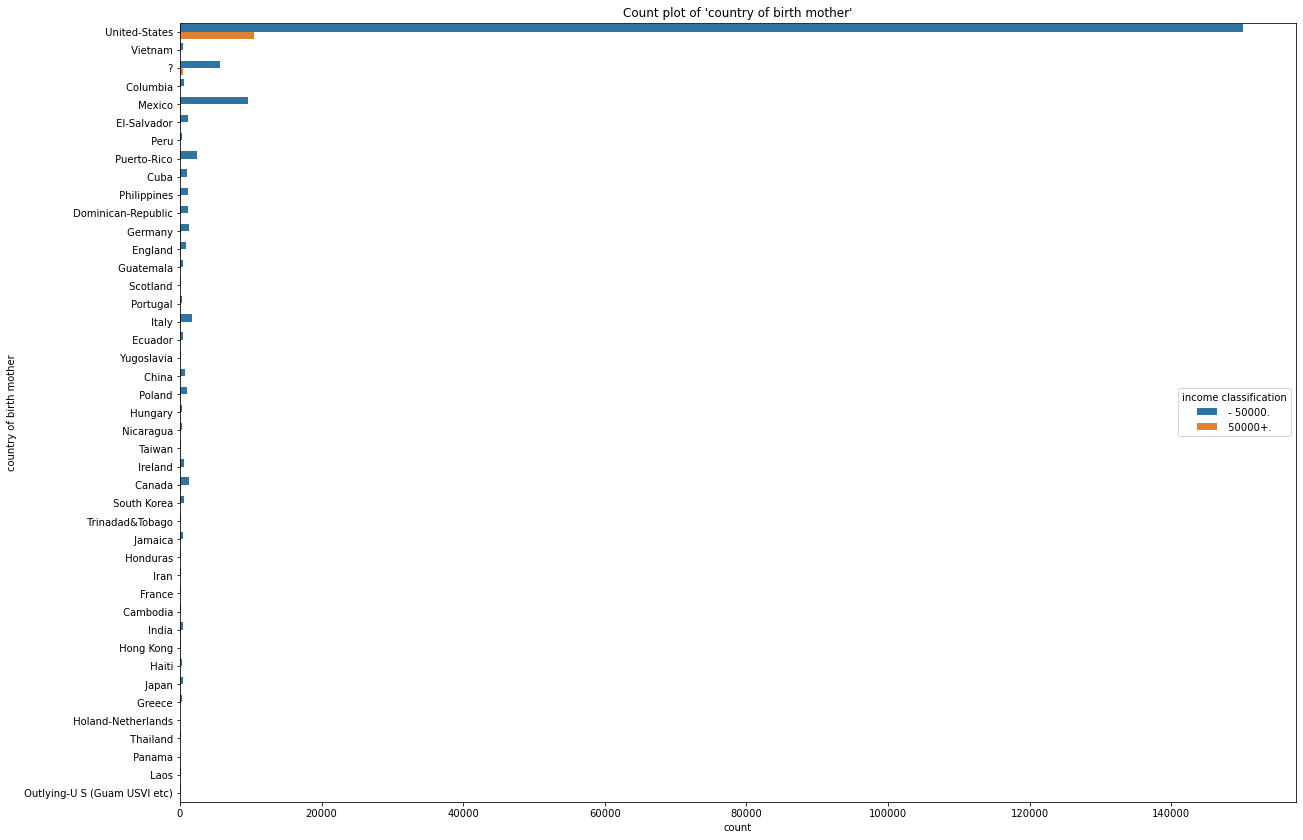

Comparing 'country of birth self' feature with the target 'income classification'


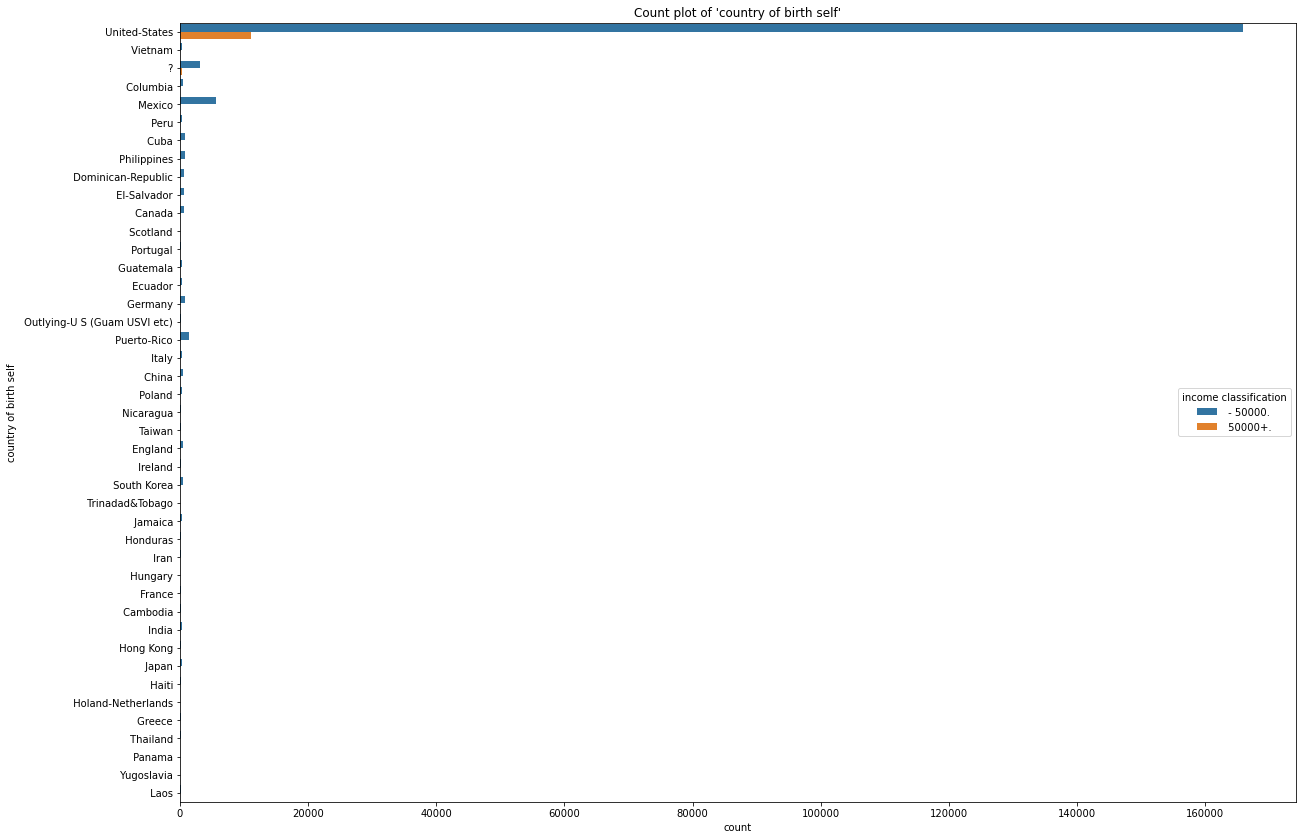

Comparing 'citizenship' feature with the target 'income classification'


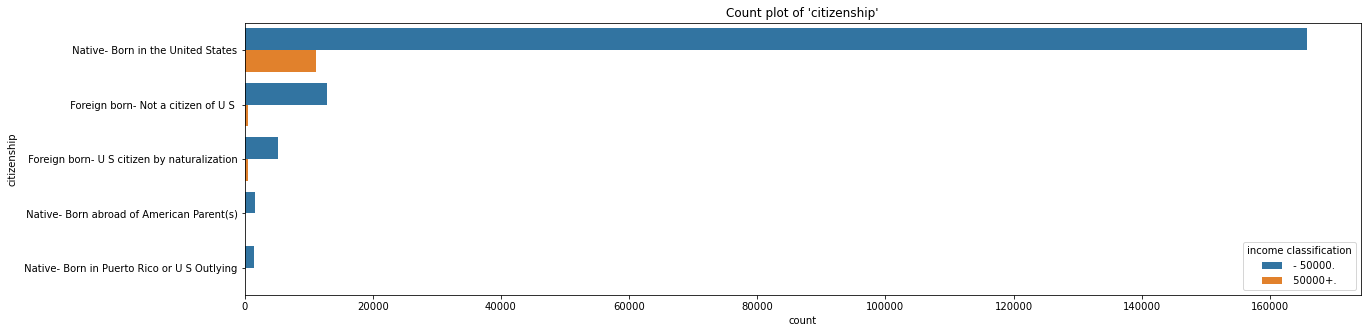

Comparing 'own business or self employed' feature with the target 'income classification'


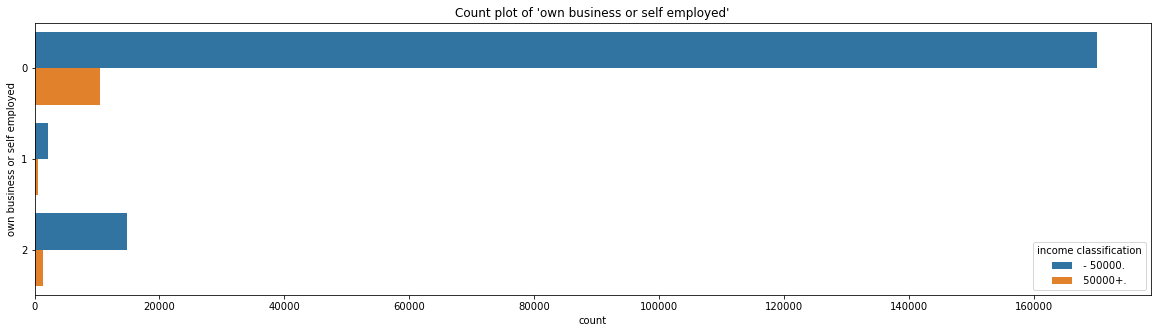

Comparing 'fill inc questionnaire for veteran's admin' feature with the target 'income classification'


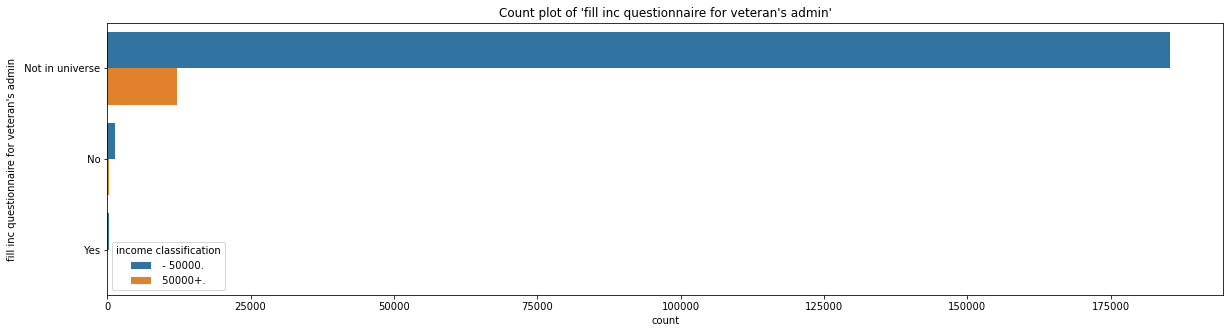

Comparing 'veterans benefits' feature with the target 'income classification'


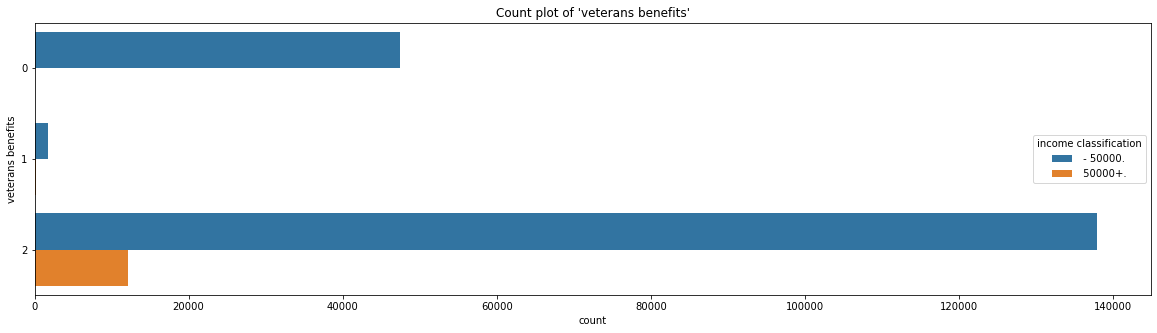

Comparing 'year' feature with the target 'income classification'


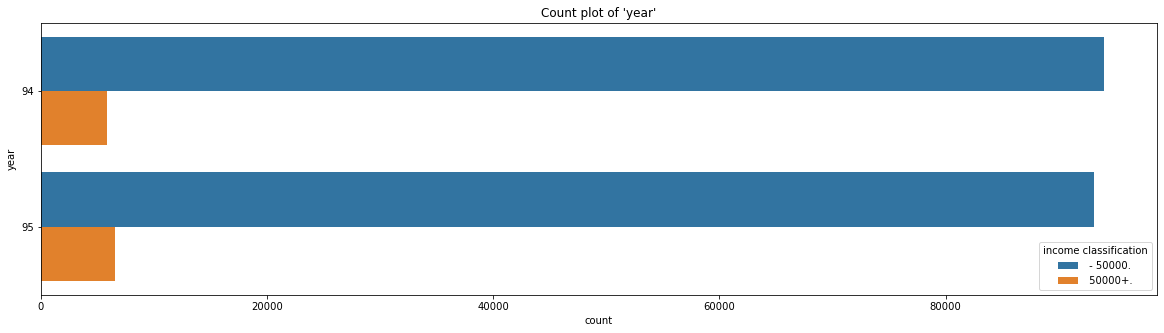

In [14]:
# Display categorical bivariate content of each feature
bivariate_categorical_viz(census_learn, categorical_features, "income classification")

#### Observation
- The private working class in the majority of the >usd50k class while be being the magority label
- The >usd50k class favors certain industries over other
- Married people are more likely to be part of the >usd50k class 
    - this is understandable as most married individuals are adults with jobs
    - the same observation can be made for those employed full time
- Being a Males greatly increases yout chances of being par of the >usd50k class with respect to being a female at the time of the census

#### Key takeaway
- Each feature can add value to a model as it relations can be infered between the feature and the target class


# 2. Cleaning data

#### Objective
In this step we clean the data to get it ready for the feature engineering. </br>
Steps:
1. Drop duplicates
2. Convert target class to binary
3. Imputing missing values (replacing the '?')

There a different ways to complete a dataset and input the missing values:
- remove all tuples with missing data
    - This method is simple and can work but in our case, more than 50% are incomplete and we can't simply remove 50% of the dataset
    - We can replace using nearest neighbor
    - Train a modele to best predict the missing value (DecisionTree, Randomforest,etc.)
    - Replace with the mean, median or mode of the set.
I have gone with the mode as it is fast to implement and works well even with categorical features

# 3. Feature Engineering - Data mining

#### Objective:
In this step we will apply feature engneering on the data to prepare it for training </br>

1. Clean and remove features we found unnecessary

2. We first had to embed the categorical features: (There are different methodes)
- Label encoding: giving a number to each label
- One hot encoding: creating one column per label (and setting the value to 1 or 0)
- Dummy encoding : Same as one hot encoding but encodes more efficiently

In this study, Label encoding has been used as it is simple to setup and the number of feature stays small. </br>
One downside to this method is that models can try to learn from the encoded order whereas there is no meaning in the order.
</br>

3. We then apply scaling to avoid giving too much importance to features that have values of high order of magniture 
- Method 1: min max scaling : brings values between a given in max to [0,1]
- Method 2: z-scaling : consists in subtracting the sample mean and dividing by the sample standard

In [15]:
# Generate features
X_train, y_train, X_test, y_test = featureEngineering(census_learn, census_test, categorical_features, "income classification")

# Example output
X_train.head()

Number of lines in the dataset before dropping duplicates: 199523
Number of lines in the dataset after dropping duplicates: 152896
Columns which have missing values before imputation:
migration code-change in msa      74944
migration code-change in reg      74944
migration code-move within reg    74944
migration prev res in sunbelt     74944
country of birth father            6383
country of birth mother            5810
country of birth self              3322
state of previous residence         698
dtype: int64
Number of lines in the dataset before dropping duplicates: 99762
Number of lines in the dataset after dropping duplicates: 78864
Columns which have missing values before imputation:
migration code-change in msa      38868
migration code-change in reg      38868
migration code-move within reg    38868
migration prev res in sunbelt     38868
country of birth father            3307
country of birth mother            2969
country of birth self              1735
state of previous res

,age,class of worker,industry code,occupation code,education,wage per hour,enrolled in edu inst last wk,marital status,major industry code,major occupation code,race,hispanic Origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer status,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year
0,1.692636,-0.515720,-1.093680,-0.985556,0.415254,-0.231756,0.258648,2.209807,0.23866,-0.109987,0.422439,-0.386771,-0.970887,0.248145,-0.035358,0.921417,-0.105844,-0.157231,-0.113655,0.636058,-0.020204,0.199763,0.146651,0.824350,0.297606,-0.006696,0.025796,-0.475778,0.085411,-1.055801,0.345317,0.424804,0.420387,0.316245,0.393517,-0.367317,0.068526,0.319836,-1.263815,1.019871
1,0.929744,1.940126,-0.874318,1.298175,1.307123,-0.231756,0.258648,-1.895497,-1.61153,0.456083,0.422439,-0.386771,1.029986,0.248145,-0.035358,-0.635726,-0.105844,-0.157231,-0.113655,-2.055372,1.888982,-5.039859,-0.217451,-0.154513,-3.380133,2.399334,2.089147,-2.030149,3.247395,-0.639812,0.345317,0.424804,0.420387,0.316245,0.393517,-0.367317,0.068526,0.319836,0.922309,-0.980516
2,-1.104636,-0.515720,-1.093680,-0.985556,-2.260354,-0.231756,-2.216857,0.841372,0.23866,-0.109987,-2.942463,-0.386771,-0.970887,0.248145,-0.035358,0.921417,-0.105844,-0.157231,-0.113655,0.636058,-0.020204,0.199763,-1.855909,-2.112237,0.297606,-0.006696,0.025796,-0.475778,0.085411,-1.055801,0.345317,0.534669,0.530831,0.452793,-2.858936,-0.367317,0.068526,0.319836,-1.263815,1.019871
3,-1.562372,-0.515720,-1.093680,-0.985556,-0.030681,-0.231756,0.258648,0.841372,0.23866,-0.109987,0.422439,-0.386771,-0.970887,0.248145,-0.035358,-0.635726,-0.105844,-0.157231,-0.113655,0.636058,-0.020204,0.199763,-1.309756,-1.133375,0.297606,-0.006696,0.025796,1.078593,0.085411,-1.055801,-3.313627,0.424804,0.420387,0.316245,0.393517,-0.367317,0.068526,-3.254978,-1.263815,-0.980516
4,-1.511512,-0.515720,-1.093680,-0.985556,-0.030681,-0.231756,0.258648,0.841372,0.23866,-0.109987,0.422439,-0.386771,-0.970887,0.248145,-0.035358,-0.635726,-0.105844,-0.157231,-0.113655,0.636058,-0.020204,0.199763,-1.309756,-1.133375,0.297606,-0.006696,0.025796,1.078593,0.085411,-1.055801,-3.313627,0.424804,0.420387,0.316245,0.393517,-0.367317,0.068526,-3.254978,-1.263815,-0.980516


# 4- Building models

### Objective
In this section the goal is to train different models</br>
For each model we will:
- Apply 5 folds cross validation
- Tune hyper parameters
- Visualise feature importance 

The models considered are:
1. Logistic regression: Using a logistic function to model the conditional probabilities P(Y=1| X) or P(Y=0|X). There is no need for a linear relationship between dependent/independent variables, neither the error terms to be normally distributed

2. Random Forest Classifier: Are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. For regression tasks, the mean or average prediction of the individual trees is returned

3. XGBoost : XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

In [16]:
# Run Logistic Regression
model_logreg = trainLogisticRegression(X_train, y_train)

Logistic Regression Model: 

CV scores = [0.93332243 0.93184865 0.93211027 0.93073678 0.93194676]
Mean CV score = 0.932
Feature importances:
age Score: 0.52950
class of worker Score: 0.04425
industry code Score: 0.09453
occupation code Score: -0.88963
education Score: 0.16901
wage per hour Score: -0.00533
enrolled in edu inst last wk Score: 0.34621
marital status Score: -0.07877
major industry code Score: -0.10791
major occupation code Score: 0.15369
race Score: 0.10418
hispanic Origin Score: -0.19986
sex Score: 0.76588
member of a labor union Score: 0.02545
reason for unemployment Score: 0.01553
full or part time employment stat Score: -0.01578
capital gains Score: 0.66721
capital losses Score: 0.20217
dividends from stocks Score: 0.48260
tax filer status Score: -0.12859
region of previous residence Score: 0.06166
state of previous residence Score: -0.01231
detailed household and family stat Score: -0.17256
detailed household summary in household Score: 0.29465
migration code-change i

In [17]:
# Run Random Forest
model_rf = trainRandomForest(X_train, y_train, 42)

Random Forest Classifier Model: 

Random search parameters = {'n_estimators': [5, 11, 17, 23, 30], 'max_features': ['auto', 'sqrt'], 'max_depth': [5], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Tuned Decision Tree Parameters: {'n_estimators': 23, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}
Best score is 0.9278594553074218
Best params are {'n_estimators': 23, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}
Feature importances:
age Score: 0.05253
class of worker Score: 0.02303
industry code Score: 0.04245
occupation code Score: 0.15377
education Score: 0.01454
wage per hour Score: 0.00116
enrolled in edu inst last wk Score: 0.00297
marital status Score: 0.00576
major industry code Score: 0.00451
major occupation code Score: 0.03377
race Score: 0.00033
hispanic Or

In [18]:
# Run XGBoost Model
model_xgb = trainXGBoost(X_train,y_train,42)

XGBoost Classifier Model: 

Random search parameters = {'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5], 'n_estimators': range(10, 40), 'learning_rate': [0.1, 0.01, 0.05]}
Fitting 5 folds for each of 5 candidates, totalling 25 fits

 All results:
{'mean_fit_time': array([3.99025259, 3.91765656, 3.61513629, 4.65148363, 3.89262943]), 'std_fit_time': array([0.30425492, 0.88935434, 0.59390383, 0.66831073, 0.66456835]), 'mean_score_time': array([0.06922855, 0.08167224, 0.06562619, 0.0703619 , 0.08726344]), 'std_score_time': array([0.00556138, 0.0240035 , 0.01436415, 0.0063785 , 0.03818096]), 'param_subsample': masked_array(data=[0.6, 1.0, 0.8, 0.8, 1.0],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[25, 26, 21, 28, 16],
             mask=[False, False, False, False, False],
       fill_valu

#### Observations:

Logistic Regression:
The most important features are:
- age Score: 0.60424
- occupation code Score: -0.86285
- sex Score: 0.76972
- capital gains Score: 0.59600
- dividends from stocks Score: 0.43903
- live in this house 1 year ago Score: 0.25593
- num persons worked for employer Score: 0.35651
- family members under 18 Score: 1.54395
- weeks worked in year Score: 1.52572
- year Score: 0.24091

Random Forest Classifier:
The most important features are:
- age Score: 0.04047
- occupation code Score: 0.32236
- marital status Score: 0.02068
- major industry code Score: 0.03042
- major occupation code Score: 0.02567
- sex Score: 0.05084
- capital gains Score: 0.21906
- capital losses Score: 0.05371
- num persons worked for employer Score: 0.09092
- weeks worked in year Score: 0.08641

XGBoost Classifier:
The most important features are:
- age Score: 0.05616
- industry code Score: 0.07737
- occupation code Score: 0.21469
- sex Score: 0.06693
- capital gains Score: 0.12906
- dividends from stocks Score: 0.06318
- detailed household summary in household Score: 0.04058
- num persons worked for employer Score: 0.07360
- weeks worked in year Score: 0.14441

#### Key Takeaway:
Over all the models gave the most importance to the same features:
- age
- sex
- weeks worked in year 
- occupation code
- capital gains


# 5- Model assesments

#### Objective
- Evaluation of each model on the testing set
- Compare each model using various scoring methods
    - accuracy
    - precision
    - recall
    - f1-score
    - confusion matrix


,accuracy,precision,recall,f1_score
Logistic Regression,0.933823,0.704786,0.268995,0.389376
Random Forest Classifier,0.926215,0.946472,0.062884,0.117932
XGBoost,0.932973,0.894046,0.165050,0.278657


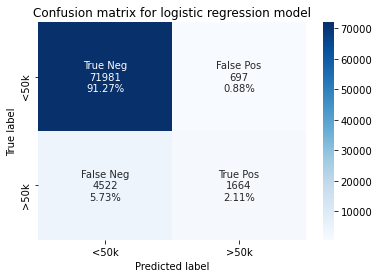

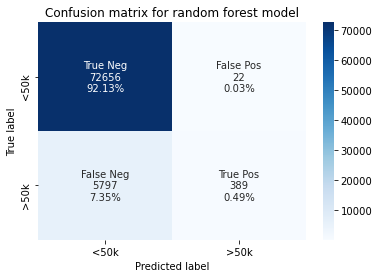

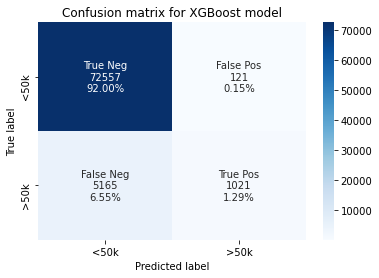

In [19]:
#  Evaluating all models on a testing set and compare them
compare_models(model_logreg, model_rf, model_xgb, X_test, y_test)

# Results / summary

#### Observations:
- In this case study, we can't only look at the accuracy to evaluate the model as the distribution of the output labels are not equaly distributed.
- Accuracy is similar for the three models but Random forest and Xgboost are ahead.
- Random Forest is more likely to predict <50k than XGBoost giving it a lower score for False Positives and False Negatives  
- XGBoost seems to be better at predicting >50k but by doing so, it's overall precision and accuracy diminished.


#### Key Takeaway:
- Logistic Regression, is as expected, falling short with respect to the other two models.
- Between Random Forest and XGboost there is no clear winner as they both have their pros and cons.
- In terms of explainability, Random Forest is more strait forward than XGBoost
- The features given the most imporance throughout the 3 models are:
   - age
   - sex
   - weeks worked in year
   - occupation code
   - capital gains


#### Possible Improvements:

- Extract more relevant features from the dataset (Ex: by combining them together)
- Encoding methodes: try either one hot enconding or dummy encodding 
- Improve on the statisitical analysis:
    - Compare categorical between each other and not only with the target.
    - Set up more statistical test to automaticaly make decision on certain variables.
- More hyperparameter training
    - Expand the search space
    - Use hyper parameter search algorithms
    - Increase the amount of runs

- Try other models: 
    - Neural Networks: Good for learning complexe structures at the cost of interpretability
    - Light GBM: it is almost 7 times faster than XGBOOST and is a much better approach when dealing with large datasets. This turns out to be a huge advantage when you are working on large datasets